# **Computer vision - Final project**

This notebook covers our final group assignment for the course 'Computer Vision'. In this assignment, the goal is to use deep learning models to classify and segment images and to investigate the weaknesses of the classification network. The notebook follows the same structure as the assignment and provides the necessary documentation. 

Group 12: Felix Cammaerts, Adnan Kaan Ekiz, Connor Alan Galvin & Jasper Penneman 

# 1) Data

In this section, the PASCAL VOC-2009 dataset is downloaded and the different images (original images, images for class segmentation, images for object segmentation) as well as the XML annotations are stored. The further processing and splitting of the data in training, validation and test set is done in each individual part of the assignment, as this was easier for the collaboration on the project. 

In [ ]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals

voc_root_folder = "/content/VOCdevkit/VOC2009"

--2020-05-30 22:00:47--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  13.7MB/s    in 68s     

2020-05-30 22:01:58 (13.1 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 257MiB/s)


In [ ]:
# Importing the necessary libraries for the preprocessing

from google.colab import drive
import cv2
import os
import torch
import numpy as np
import torchvision.transforms as transforms
from pathlib import Path
from urllib import request
from google.colab import drive
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET

In [ ]:
# Getting the image names and the images themselves

org_img = []
org_img_names = []
org_ann = []
seg_cls = []
seg_cls_names = []
seg_obj = []
seg_obj_names = []

# Declaring the directories

org_img_root = "/content/VOCdevkit/VOC2009/JPEGImages"
org_ann_root = "/content/VOCdevkit/VOC2009/Annotations"
seg_cls_root = "/content/VOCdevkit/VOC2009/SegmentationClass"
seg_obj_root = "/content/VOCdevkit/VOC2009/SegmentationObject"

**Uploading every image from the database to the memory to use it in preprocessing**

In [ ]:
# Store all original image names (e.g. 2009_002335.jpg) in org_img_names
with os.scandir(org_img_root) as entries:
  for entry in entries:
    org_img_names.append(entry.name)
    #print(entry.name)

# Sort org_img_names by name
org_img_names.sort()
print(org_img_names[0])

# Store all original images (RGB images) in org_img
for str in org_img_names:
    img_path = org_img_root + "/" + str
    img = cv2.imread(img_path)
    org_img.append(img)

# Check if org_img and org_img_names have equal number of objects (7818 images)
print( len(org_img) )
print( len(org_img_names) )

# store all xml-annotations for original images in org_ann
# xml-files have same name as original image names
with os.scandir(org_ann_root) as entries:
  for entry in entries:
    ann_path = org_ann_root + "/" + entry.name
    img = cv2.imread(img_path)
    org_ann.append(ann_path)

# check if number of annotations is equal to number of original images (7818) 
print(len(org_ann) )

# Store all segmentation class image names in seg_cls_names
with os.scandir(seg_cls_root) as entries:
  for entry in entries:
    seg_cls_names.append(entry.name)
    #print(entry.name)

# Sort seg_cls_names by name
seg_cls_names.sort()
print(seg_cls_names[0])

# Store all segmentation class images (RGB) in seg_cls
for str in seg_cls_names:
    img_path = seg_cls_root + "/" + str
    img = cv2.imread(img_path)
    seg_cls.append(img)

# Check if seg_cls and seg_cls_names have equal number of objects (1499 images)
print( len(seg_cls) )
print( len(seg_cls_names) )

# Store all segmentation object image names in seg_obj_names
with os.scandir(seg_obj_root) as entries:
  for entry in entries:
    seg_obj_names.append(entry.name)
    #print(entry.name)

# Sort seg_obj_names by name
seg_obj_names.sort()
print(seg_obj_names[0])

# store all segmentation object images (RGB) in seg_obj
for str in seg_obj_names:
    img_path = seg_obj_root + "/" + str
    img = cv2.imread(img_path)
    seg_obj.append(img)

# check if seg_obj and seg_obj_names have equal number of objects (1499)
print( len(seg_obj) )
print( len(seg_obj_names) )

2007_000027.jpg
7818
7818
7818
2007_000032.png
1499
1499
2007_000032.png
1499
1499


**Showing an instance of images that is going to be used**

Note that in class segmentation every class has the same color and in object segmentation every object has a different color regardless of the class.

Class Segmentation Instance


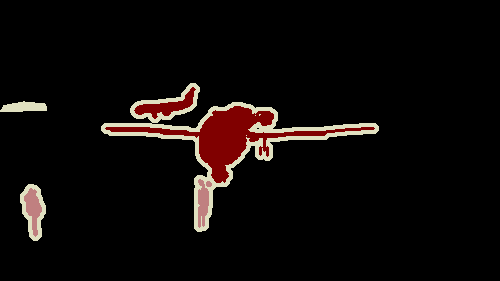

Object Segmentation Instance


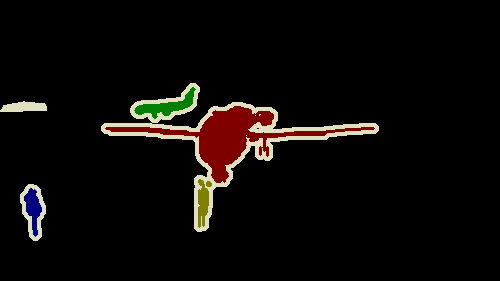

In [ ]:
# show example of seg_cls
# seg_cls: each class has 1 color so no distinction between objects of same class 
print("Class Segmentation Instance")
cv2_imshow(seg_cls[0])
# show example of seg_obj
# seg_obj: each object has different color, so objects of same class have different colors
# this is the difference with seg_cls!
print("Object Segmentation Instance")
cv2_imshow(seg_obj[0])

# 2) Assignment 1: Supervised, end-to-end learning



## 2.1) Task 1: Classification

The images contain multiple objects of different classes.

The code below creates a list of the class and a list of the bounding box coordinates of the largest object in the image.

In [ ]:
from bs4 import BeautifulSoup

org_ann.sort()

class_list = []
box_list = []

for xml_filename in org_ann:
  with open(xml_filename) as description:
      soup = BeautifulSoup(description)
      objects = soup.annotation.findAll("object")
      size_list = []
      name_list= []
      bounding_list= []
      for obj in objects:
        names = obj.findAll("name")
        b_boxes = obj.findAll("bndbox")
        for name in names:
          name_list.append(name.string)
        for box in b_boxes:
          xmin = int(box.xmin.string)
          xmax = int(box.xmax.string)
          ymin = int(box.ymin.string)
          ymax = int(box.ymax.string)
          obj_size = (ymax-ymin)*(xmax-xmin)
          size_list.append(obj_size)
          bounding_list.append([xmin, xmax, ymin, ymax])
      max_index = size_list.index(max(size_list))
      class_label = name_list[max_index]
      bounding_box = bounding_list[max_index]
      class_list.append(class_label)
      box_list.append(bounding_box)


print(class_list[0:10])
print(box_list[0:10])

print(len(class_list))
print(len(box_list))

['person', 'aeroplane', 'aeroplane', 'tvmonitor', 'train', 'boat', 'chair', 'bird', 'tvmonitor', 'train']
[[174, 349, 101, 351], [104, 375, 78, 183], [9, 499, 107, 263], [156, 344, 89, 279], [263, 500, 32, 295], [274, 437, 11, 279], [75, 428, 1, 375], [27, 266, 45, 375], [22, 251, 28, 273], [1, 358, 26, 340]]
7818
7818


### 2.1.1) From scratch

In this section we will try to classify all images by training our own model on a well known architecture. The model will be trained to recognize the 20 classes of the dataset. The expected class of an image with multiple objects in it is always the class of the biggest object. In the dataset however sometimes a picture has not been labelled as being a person but only consisting of a hand, foot or head. We will change these classes to be labelled to the class 'person' as well, as otherwise we would have 23 classses instead of 20.

Firstly we'll make a list of all possible classes there are i.e. the 23 classes that the dataset consists of without 'hand, 'foot' and 'head'.

In [ ]:
classes_classification = list(set(class_list) - {'hand', 'foot', 'head'})
print(classes_classification)
print(len(classes_classification))

['aeroplane', 'sofa', 'sheep', 'car', 'cow', 'pottedplant', 'person', 'diningtable', 'tvmonitor', 'chair', 'bottle', 'train', 'bicycle', 'dog', 'boat', 'horse', 'bird', 'motorbike', 'bus', 'cat']
20


Next we will split our dataset into a training, validation and test set. The training set is used for the training of the model i.e. these are the only examples the model will learn with. The validation set is kept aside and used after every epoch of training to measure the accuracy of the partially trained model on unseen examples. Lastly the test set is a set that is kept aside till the very end and used to measure the accuracy of unseen examples for the model after all training has come to an end. Here we opt for a 70-20-10 split. Meaning that the training, validation and test sets respectively consist of 70%, 20% and 10% of all examples.

The below code will split the dataset in to the sizes discussed above and make a list of all image names which will be used for the training, validation and test sets.

In [ ]:
import numpy as numpy

x = np.array(org_img_names)
indices = numpy.random.RandomState(42).permutation(x.shape[0])
first_split = int(0.7*len(indices))
second_split = int(0.9*len(indices))
training_idx, validation_idx, test_idx = indices[:first_split], indices[first_split:second_split], indices[second_split:]
training_imgs_names_cnn, val_imgs_names_cnn, test_imgs_names_cnn = x[training_idx], x[validation_idx], x[test_idx]

#### Unaugmented data

In this section we will train our classifier without augmenting the training set, in the next section we will augment the training set and compare the results.

Now that we have the names of all images we want to use in each of the seperate sets, we can actually retrieve those images and match them with the corresponding label. We also crop the images to be of size 32x32 and only keep the part of the image with the object of interest in it. The cropping of the image to only contain the object of interest is done first, after which the resizing happens. If an image is labelled to be a 'hand', 'foot' or 'head', the code below will change it to be labelled 'person'.

As Tensorflow does not allow for strings as input labels to the model, we are not able to use the classes directly. Our solution to this is to change the class names to be integers, this can easily be done by taking the index of the class list for the wanted class.

In [ ]:
img_size = 32

train_images = []
train_labels = []

for i in range(len(training_imgs_names_cnn)):
  name = training_imgs_names_cnn[i]
  if name in org_img_names:
    org_index = org_img_names.index(name)
    box = box_list[org_index]
    image = org_img[org_index]
    cropped_image = image[box[2]:box[3],box[0]:box[1]]
    resized_image = cv2.resize(cropped_image, (img_size,img_size), interpolation=cv2.INTER_AREA)
    train_images.append(resized_image)
    if class_list[org_index] in ['hand', 'foot', 'head']:
      class_index = classes_classification.index('person')
    else:
      class_index = classes_classification.index(class_list[org_index])
    train_labels.append(class_index)


val_images = []
val_labels = []

for i in range(len(val_imgs_names_cnn)):
  name = val_imgs_names_cnn[i]
  if name in org_img_names:
    org_index = org_img_names.index(name)
    box = box_list[org_index]
    image = org_img[org_index]
    cropped_image = image[box[2]:box[3],box[0]:box[1]]
    resized_image = cv2.resize(cropped_image, (img_size,img_size), interpolation=cv2.INTER_AREA)
    val_images.append(resized_image)
    if class_list[org_index] in ['hand', 'foot', 'head']:
      class_index = classes_classification.index('person')
    else:
      class_index = classes_classification.index(class_list[org_index])
    val_labels.append(class_index)


test_images = []
test_labels = []

for i in range(len(test_imgs_names_cnn)):
   name = test_imgs_names_cnn[i]
   if name in org_img_names:
     org_index = org_img_names.index(name)
     box = box_list[org_index]
     image = org_img[org_index]
     cropped_image = image[box[2]:box[3],box[0]:box[1]]
     resized_image = cv2.resize(cropped_image, (img_size,img_size), interpolation=cv2.INTER_AREA)
     test_images.append(resized_image)
     if class_list[org_index] in ['hand', 'foot', 'head']:
       class_index = classes_classification.index('person')
     else:
       class_index = classes_classification.index(class_list[org_index])
     test_labels.append(class_index)


Let's do a little sanity check and check whether we actually have the right amount of examples in each of the sets.

In [ ]:
print("Training images size: {}".format(len(train_images)))
print("Training labels size: {}".format(len(train_labels)))

print("Validation images size: {}".format(len(val_images)))
print("Validation labels size: {}".format(len(val_labels)))

print("Test images size: {}".format(len(test_images)))
print("Test labels size: {}".format(len(test_labels)))

Training images size: 5472
Training labels size: 5472
Validation images size: 1564
Validation labels size: 1564
Test images size: 782
Test labels size: 782


Great, seems to be correct! Let's also quickly check if the images have been labelled correctly.

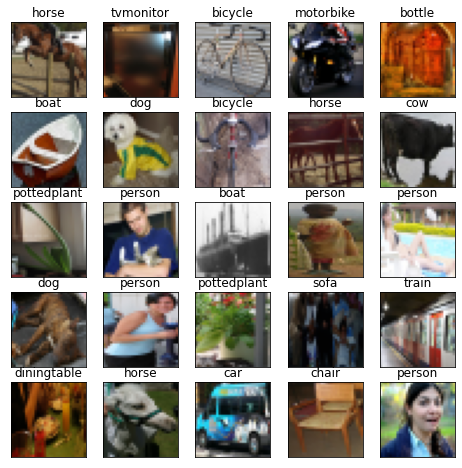

In [ ]:
import matplotlib.pyplot as plt 

images = []
titles = []
for i in range(25, 50):
  img = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB)
  images.append(img)
  titles.append(classes_classification[train_labels[i]])

plt.figure(figsize=(8, 8))

n_row = 5
n_col = 5
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i])
    plt.xticks(())
    plt.yticks(())

The training images seem to be labelled correctly, now let's see for the validation images:

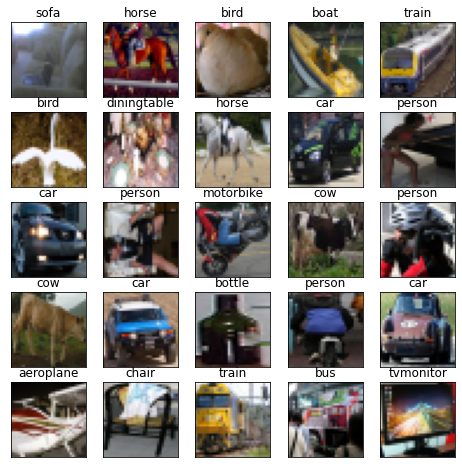

In [ ]:
images = []
titles = []
for i in range(25):
  img = cv2.cvtColor(val_images[i], cv2.COLOR_BGR2RGB)
  images.append(img)
  titles.append(classes_classification[val_labels[i]])

plt.figure(figsize=(8, 8))
n_row = 5
n_col = 5
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i])
    plt.xticks(())
    plt.yticks(())

And finally for the test images:

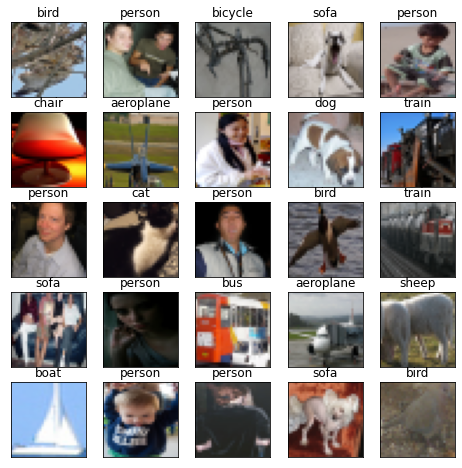

In [ ]:
images = []
titles = []
for i in range(25):
  img = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB)
  images.append(img)
  titles.append(classes_classification[test_labels[i]])

plt.figure(figsize=(8, 8))
n_row = 5
n_col = 5
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i])
    plt.xticks(())
    plt.yticks(())

Let's have a look at the class distributions in each of our data sets

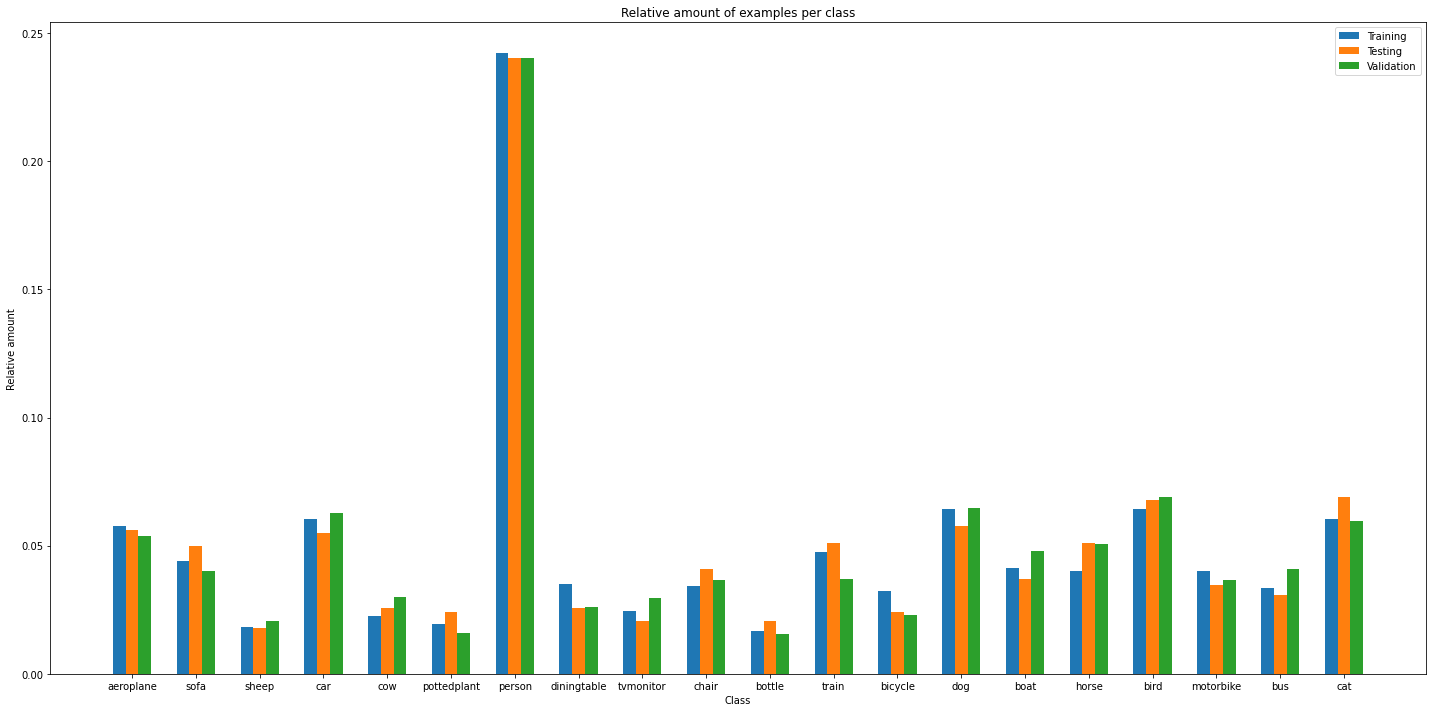

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = []
training_amount = []
testing_amount = []
val_amount = []

for i in range(len(classes_classification)):
  labels.append(classes_classification[i])
  training_amount.append(train_labels.count(i)/len(train_labels))
  testing_amount.append(test_labels.count(i)/len(test_labels))
  val_amount.append(val_labels.count(i)/len(val_labels))

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width, training_amount, width, label='Training')
rects2 = ax.bar(x, testing_amount, width, label='Testing')
rects3 = ax.bar(x + width, val_amount, width, label='Validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative amount')
ax.set_xlabel('Class')
ax.set_title('Relative amount of examples per class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

We see that most classes have an equal presence in all of the datasets, which is good!

Now we convert our lists to array so we can use it as input to our model

In [ ]:
train_images_array = np.asarray(train_images)
train_labels_array = np.asarray(train_labels)
test_images_array = np.asarray(test_images)
test_labels_array = np.asarray(test_labels)
val_images_array = np.asarray(val_images)
val_labels_array = np.asarray(val_labels)

One last preprocessing step is to convert the labels to a one hot encoding and to normalize the images by dividing them by 255.

In [ ]:
from keras.utils import np_utils

X_train = train_images_array.astype('float32')
X_train /= 255

X_val = val_images_array.astype('float32')
X_val /= 255

X_test = test_images_array.astype('float32')
X_test /= 255

Y_train = np_utils.to_categorical(train_labels_array, 20)
Y_val = np_utils.to_categorical(val_labels_array, 20)
Y_test = np_utils.to_categorical(test_labels_array, 20)

Using TensorFlow backend.


Here we build the model and give the training and validation set as input. The first layer of the model takes a 32x32x3 input which is the size of our images and the last dimension is the RGB dimension. The Conv2D layers take a convolution with a kernel of size 3x3 where the first given parameter is the amount of neurons in the layer, so the input layer consists of 50 neurons. we also apply padding and use ReLU as activation function. The sliding window for the convulotion is set to move by 1 in both dimensions, as defined by the strides parameter. The MaxPool2D layer takes a max pool of the previous layer with a pool size of 2x2, these will calculate the highest value in every 2x2 patch and only keep those values. The dropout layers drop the specified percentage of neurons with the least weight in it. The flattening layer allows for the model to convert a 2D array into a single vector that can than be used as input to a fully connected neural network classifier. There are also multiple Dense layers, these are actually the same as linear layers i.e. they compute a linear function given the value of the previous layer. However a dense layer also uses an activation function after computing the linear function. In the first two cases ReLU is used and in the last one softmax is used. The last layer consists of 20 neurons, this allows for the last layer of the model to output a probability distribution where the class with the highest probability is the predicted class. Each of the 20 neurons corresponds to one of the classes. The validation images and labels are also provided to the model so that the progress on unseen examples can be tracked troughout the learning.

The model is then trained with a batch size of 128 images and 40 epochs. One epoch is one time the model covers all training examples. So if the batch size is 100 and the training set consists of 1000 images then one epoch would consist of 10 iterations.

As loss function we use categorical crossentropy as this loss function is a combination of cross entropy loss and softmax activation. The cross entropy loss is relevant as we are trying to classify examples in to multiple classes and the softmax activation is important because that is the output of our model.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.models import model_from_json
import tensorflow as tf

model = Sequential()

model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu', input_shape=(32, 32, 3)))

model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(20, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

history = model.fit(X_train, Y_train, batch_size=128, epochs=40, validation_data=(X_val, Y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 50)        1400      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 75)        33825     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 75)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 125)       84500     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 125)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 125)        

Let's plot how our accuracy improved over the different epochs while learning our model.

0.4680306911468506
              precision    recall  f1-score   support

           0       0.56      0.57      0.56        44
           1       0.29      0.18      0.22        39
           2       0.57      0.29      0.38        14
           3       0.43      0.56      0.48        43
           4       0.31      0.20      0.24        20
           5       0.50      0.26      0.34        19
           6       0.62      0.89      0.73       188
           7       0.33      0.35      0.34        20
           8       0.83      0.94      0.88        16
           9       0.29      0.16      0.20        32
          10       0.36      0.31      0.33        16
          11       0.55      0.45      0.49        40
          12       0.80      0.63      0.71        19
          13       0.19      0.20      0.20        45
          14       0.60      0.31      0.41        29
          15       0.61      0.47      0.54        40
          16       0.54      0.36      0.43        53
        

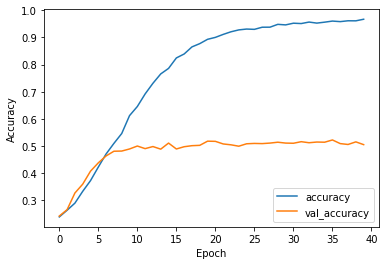

In [ ]:
from sklearn.metrics import classification_report

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images_array,  Y_test, verbose=2)
print(test_acc)

predIdxs = model.predict(X_test)
predIdxs = np.argmax(predIdxs, axis=1)
ytest_values = np.argmax(Y_test, axis=1)
print(classification_report(ytest_values, predIdxs))

We see that the accuracy of the training set gets saturated after approximately 20 epochs, after which it remains very close to a 90% accuracy. However the accuracy of the validation set plateaus after about 10 epochs, meaning that the model is not learning anything useful to apply on unseen data from that point on. The accuracy of the validation set remains at about 45% throughout the rest of the epochs. The training converged in the last few epochs as it can be seen that the accuracy of the training set barely changes anymore at that point.

We have an accuracy on our test set of approximately 45% which is quite good considering that the accuracy of a random classifier would be around 5% as we have 20 different classes.

Besides that as accuracy measure we also have the precision, recall, F1 score and support for each of the classes. For each of these measures, except for the support a higher number is better. The support just informs us how many instances of those classes were found in the test set as true labels. We see that some classes have a precision and F1 score going as high as 0.7 while others have a score of less than 0.5 for these measures.

It is also important to notice that these results are slightly better due to the fact that our testing and validation images were already zoomed in onto the object of interest, which would not be the case in a real world scenario. This is however countered by the fact that as labels we only looked at the label of the biggest object present in an image, meaning that if for instance a dog was laying on a sofa, the sofa would be the label. If our model then predicts the image to be a dog it would be considered incorrect.

Let's analyze the results of our model a bit more!

The code below plots the relative amount of instances of all classes that were predicted in our testing set next to the expected amounts.

782/782 [==============================] - 0s 80us/step


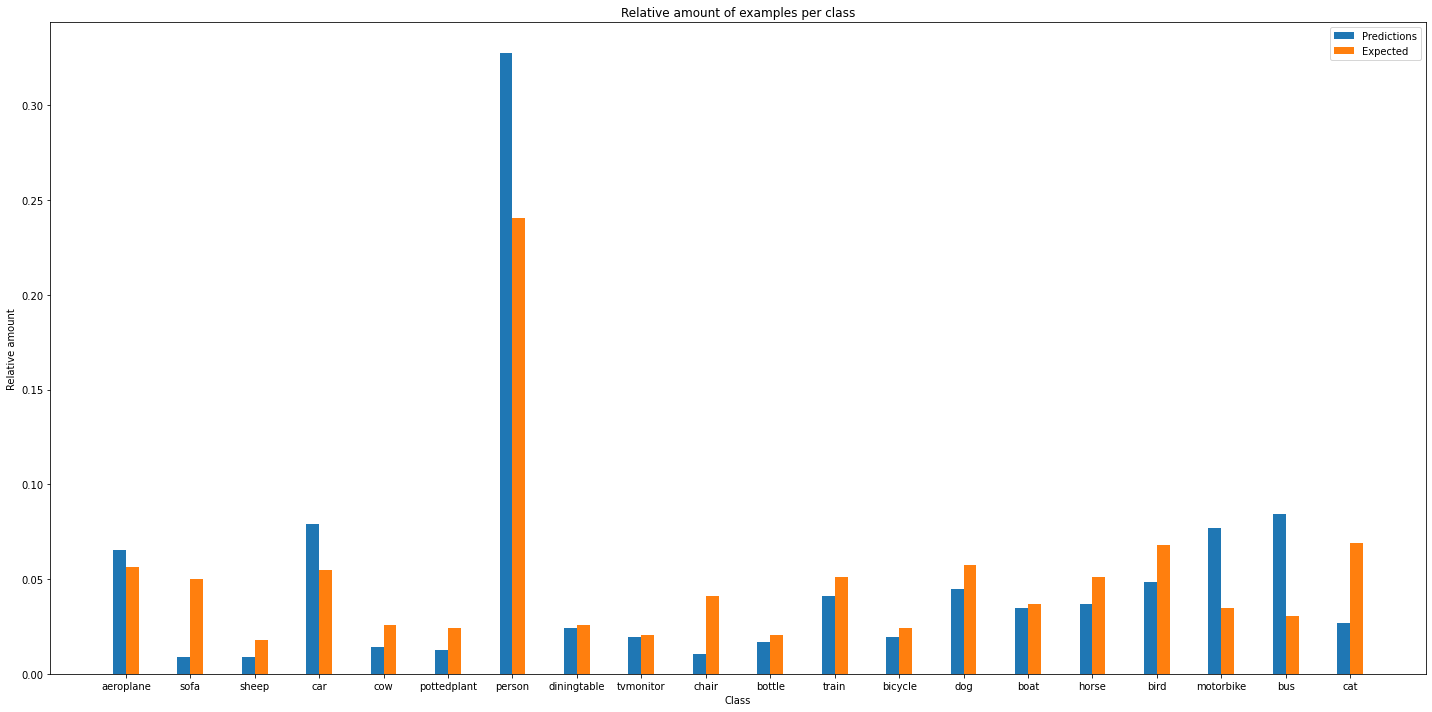

In [ ]:
labels = []
prediction_counts = []
expected_counts = []
val_amount = []

predictions = model.predict_classes(test_images_array, verbose=1)
predictions = list(predictions)
expected = list(test_labels_array)

for i in range(len(classes_classification)):
  labels.append(classes_classification[i])
  prediction_counts.append(predictions.count(i)/len(predictions))
  expected_counts.append(expected.count(i)/len(predictions))

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, prediction_counts, width, label='Predictions')
rects2 = ax.bar(x + width/2, expected_counts, width, label='Expected')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative amount')
ax.set_xlabel('Class')
ax.set_title('Relative amount of examples per class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

We see that for most classes the amount of predicted instances is close to the amount of actual instances. This is a good sign as it shows that our model does not just blindly predict every image to be a person as this is the biggest class. However this does not mean that it are the correct images that are receiving these labels, therefore we also need to look at the distributions within the classes themselves.

We have a look at how many instances of classes had been labelled correctly by our model and compare that to the amount of instances of the classes that received a wrong label. We see that things look a lot less positive now.

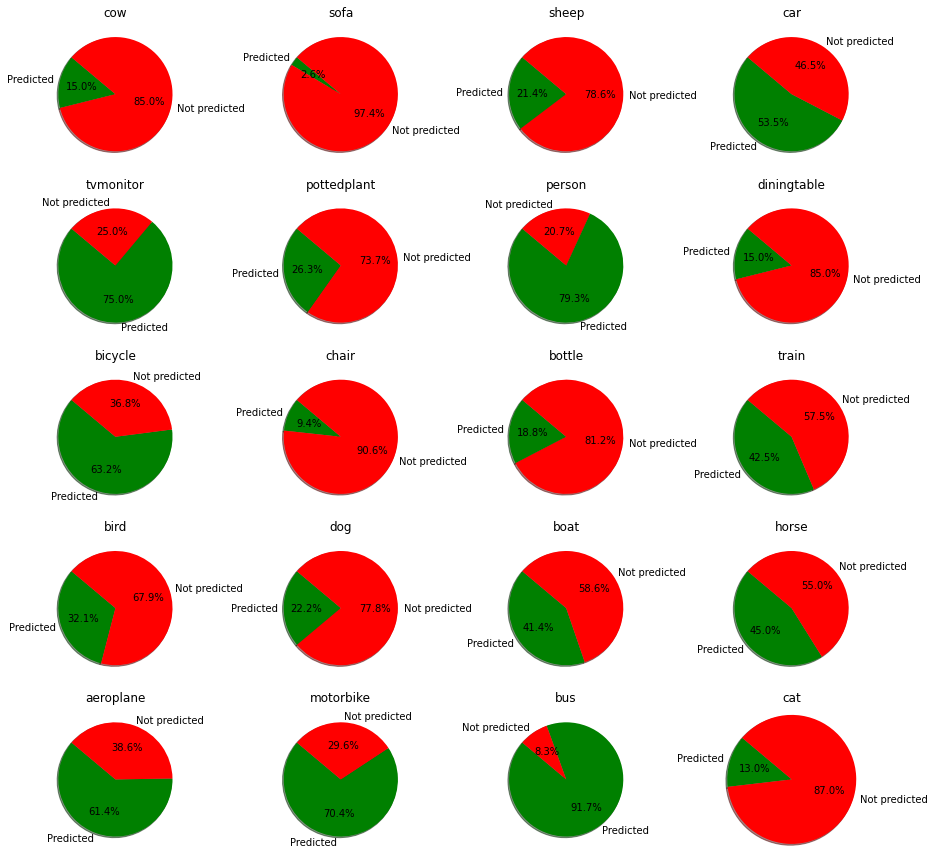

In [ ]:
correct_counts = []
for i in range(0,20):
  correct = 0
  incorrect = 0
  for j in range(0, len(predictions)):
    if expected[j] == i and predictions[j] == i:
      correct += 1
    elif expected[j] == i and predictions[j] != i:
      incorrect += 1
  correct_counts.append([correct, incorrect])

import matplotlib.pyplot as plt
import math

fig, axs = plt.subplots(5, 4)
plt.subplots_adjust(left=3, right=5, top=3)
for i in range(len(classes_classification)):
  # Data to plot
  labels = ['Predicted', 'Not predicted']
  sizes = [correct_counts[i][0], correct_counts[i][1]]
  colors = ['green', 'red']


  # Plot
  axs[math.ceil(i / 4)-1, (i % 4)].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, radius=1)
  axs[math.ceil(i / 4)-1, (i % 4)].title.set_text(classes_classification[i])

  plt.axis('equal')


Here we see that a lot of classes have been predicted quite badly with over 50% not receiving the correct label. Nonetheless there are also classes for which the opposite is true. However the latter unfortunately holds for the lesser amount of the classes.

Finally we export the weights of our model.

In [ ]:
model_json = model.to_json()
with open("model_cnn_scratch_unaugmented.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_cnn_scratch_unaugmented.h5")
print("Saved model to disk")

Saved model to disk


#### Augmented data
Here we will apply data augmentation and see whether it is able to improve our model. The validation and test set remain the same as previously. However we will create a new training set by adding the original training images and their augmentations. Augmentations are image manipulations which allow the model to become more robust against for instance different angles and lighting on the object of interest. 

Here we apply 4 augmentations:
- Flipping the image
- Rotating the image 90 degrees
- Increasing the brightness of the image
- Increasing the saturation of the image 

We add all these seperate augmentations to our training set alongside the original images

In [ ]:
import tensorflow as tf

train_images = []
train_labels = []

for i in range(len(training_imgs_names_cnn)):
  name = training_imgs_names_cnn[i]
  if name in org_img_names:
    org_index = org_img_names.index(name)
    box = box_list[org_index]
    image = org_img[org_index]

    if class_list[org_index] in ['hand', 'foot', 'head']:
      class_index = classes_classification.index('person')
    else:
      class_index = classes_classification.index(class_list[org_index])

    cropped_image = image[box[2]:box[3],box[0]:box[1]]
    resized_image = cv2.resize(cropped_image, (img_size,img_size), interpolation=cv2.INTER_AREA)
    train_images.append(resized_image)
    train_labels.append(class_index)

    flipped_image = cv2.flip(resized_image, 1)
    train_images.append(flipped_image)
    train_labels.append(class_index)

    transposed_img = cv2.transpose(resized_image)
    rotated_img = cv2.flip(transposed_img, flipCode=0)
    rotated_img = cv2.flip(rotated_img, 2)
    train_images.append(rotated_img)
    train_labels.append(class_index)

    brightened_image = tf.image.adjust_brightness(resized_image, 0.4)
    train_images.append(brightened_image.numpy())
    train_labels.append(class_index)

    saturated = tf.image.adjust_saturation(resized_image, 3)
    train_images.append(saturated.numpy())
    train_labels.append(class_index)

This means that our training set is now 5 times larger than what it used to be!

In [ ]:
print("Training images size: {}".format(len(train_images)))
print("Training labels size: {}".format(len(train_labels)))

Training images size: 27360
Training labels size: 27360


Let's take a look at what the augmentations actually look like

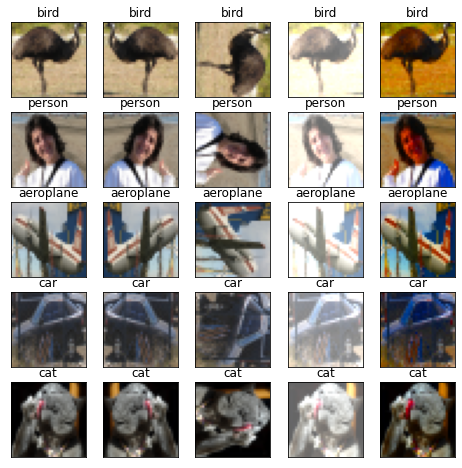

In [ ]:
import matplotlib.pyplot as plt 

images = []
titles = []
for i in range(7000, 7025):
  img = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB)
  images.append(img)
  titles.append(classes_classification[train_labels[i]])

plt.figure(figsize=(8, 8))

n_row = 5
n_col = 5
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i])
    plt.xticks(())
    plt.yticks(())

We now have 5 images for every training image. The first one being the original one, the second one a flipped image, the third one an image rotated 90 degrees clockwise, an image with increased brightness and finally an image with increased saturation.

Let's prepare our training set for our model as we did for the unaugmented data. The validation and test data from the previous section can simply be reused here.

In [ ]:
train_images_array = np.asarray(train_images)
train_labels_array = np.asarray(train_labels)

X_train = train_images_array.astype('float32')
X_train /= 255
Y_train = np_utils.to_categorical(train_labels_array, 20)

Now we can train our model on the same architecture as we had before.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten

model = Sequential()

model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu', input_shape=(32, 32, 3)))

model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(20, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

history = model.fit(X_train, Y_train, batch_size=128, epochs=40, validation_data=(X_val, Y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 50)        1400      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 75)        33825     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 75)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 75)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 125)       84500     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 125)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 125)        

We now do the same analysis to be able to compare our results.

0.41943734884262085
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        44
           1       0.34      0.28      0.31        39
           2       0.58      0.50      0.54        14
           3       0.64      0.65      0.64        43
           4       0.41      0.35      0.38        20
           5       0.58      0.37      0.45        19
           6       0.67      0.79      0.72       188
           7       0.50      0.45      0.47        20
           8       0.68      0.94      0.79        16
           9       0.35      0.19      0.24        32
          10       0.83      0.31      0.45        16
          11       0.70      0.53      0.60        40
          12       0.60      0.79      0.68        19
          13       0.23      0.31      0.26        45
          14       0.58      0.38      0.46        29
          15       0.57      0.53      0.55        40
          16       0.47      0.36      0.41        53
       

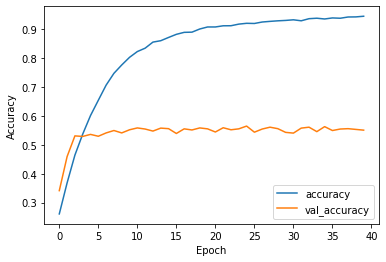

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images_array,  Y_test, verbose=2)
print(test_acc)

predIdxs = model.predict(X_test)
predIdxs = np.argmax(predIdxs, axis=1)
ytest_values = np.argmax(Y_test, axis=1)
print(classification_report(ytest_values, predIdxs))

We see that the accuracy of the training set increases in approximately the same way as with the unaugmented data. However the accuracy of the validation set is slightly better trailing around 55% after 5 epochs. The accuracy of our test set has also slightly decreased however it is still close to 45%. For the other metrics the same can be said as for the unaugmented data: there are classes with relatively good results, while there are also classes with relatively poor results.

782/782 [==============================] - 0s 81us/step


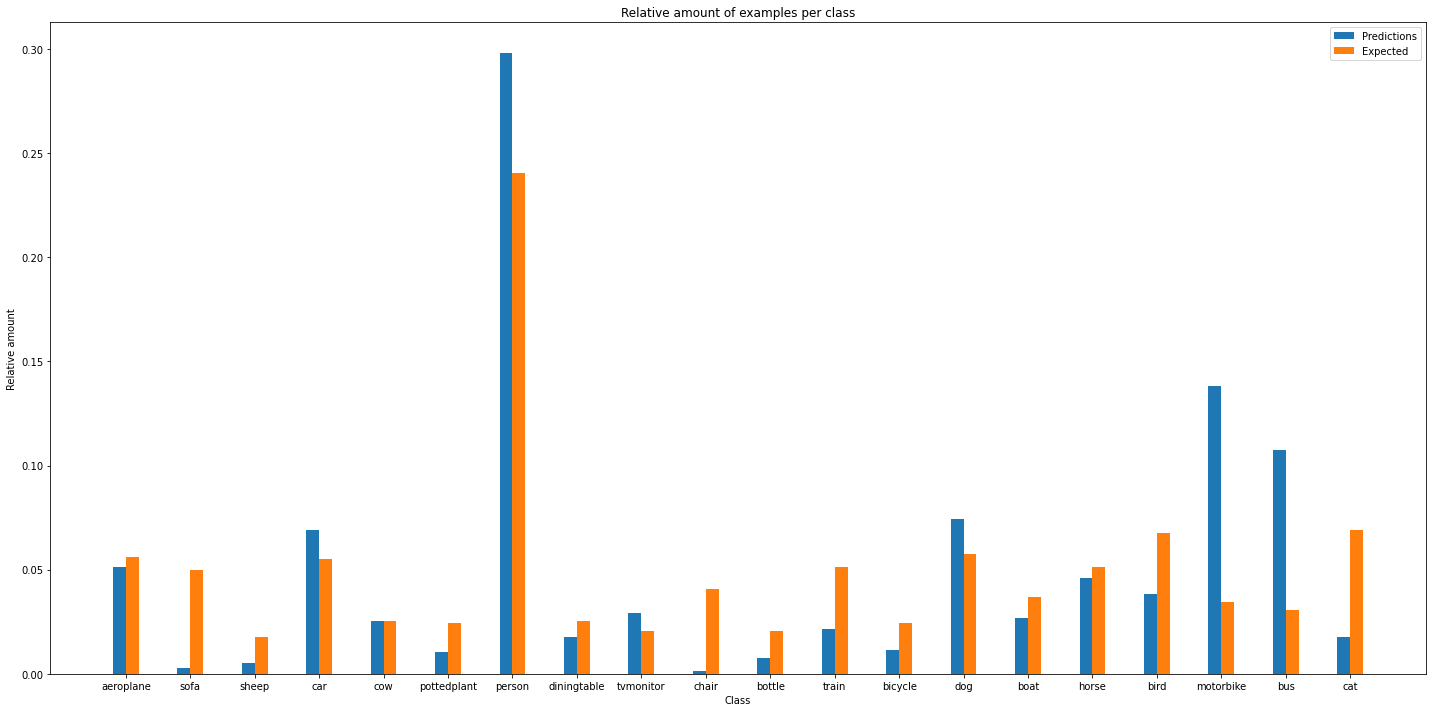

In [ ]:
labels = []
prediction_counts = []
expected_counts = []
val_amount = []

predictions = model.predict_classes(test_images_array, verbose=1)
predictions = list(predictions)
expected = list(test_labels_array)

for i in range(len(classes_classification)):
  labels.append(classes_classification[i])
  prediction_counts.append(predictions.count(i)/len(predictions))
  expected_counts.append(expected.count(i)/len(predictions))

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, prediction_counts, width, label='Predictions')
rects2 = ax.bar(x + width/2, expected_counts, width, label='Expected')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative amount')
ax.set_xlabel('Class')
ax.set_title('Relative amount of examples per class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Here we can conclude just as we did for the unaugmented data that the amount of predictions per class seems correct.

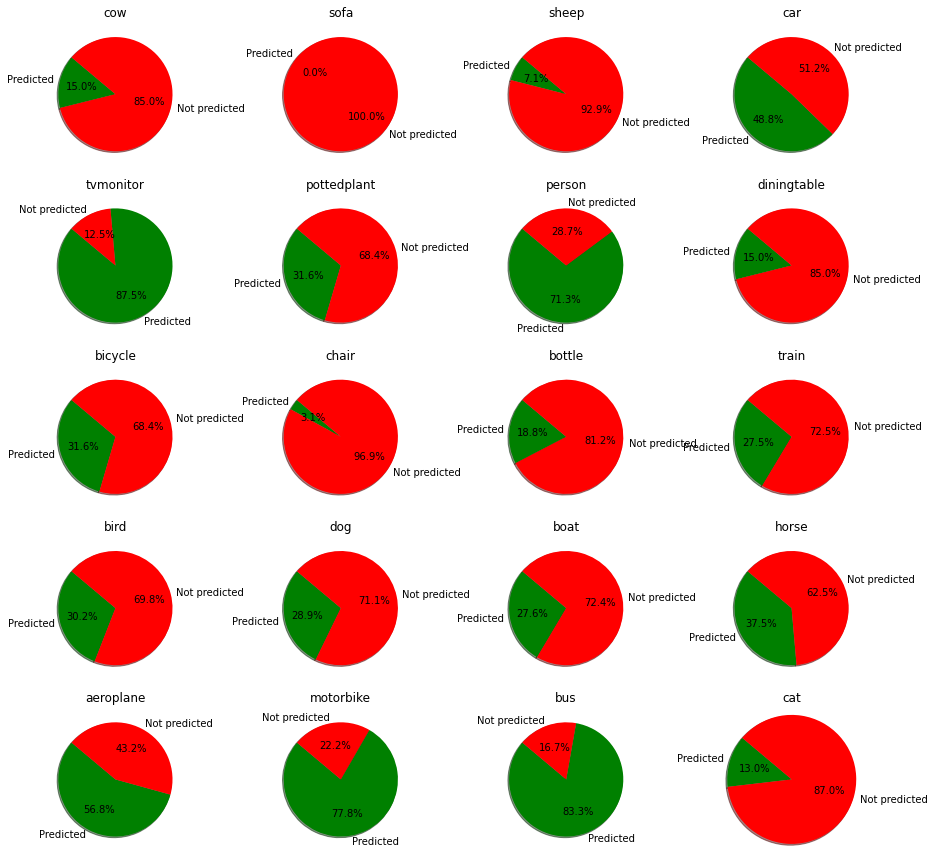

In [ ]:
correct_counts = []
for i in range(0,20):
  correct = 0
  incorrect = 0
  for j in range(0, len(predictions)):
    if expected[j] == i and predictions[j] == i:
      correct += 1
    elif expected[j] == i and predictions[j] != i:
      incorrect += 1
  correct_counts.append([correct, incorrect])

import matplotlib.pyplot as plt
import math

fig, axs = plt.subplots(5, 4)
plt.subplots_adjust(left=3, right=5, top=3)
for i in range(len(classes_classification)):
  # Data to plot
  labels = ['Predicted', 'Not predicted']
  sizes = [correct_counts[i][0], correct_counts[i][1]]
  colors = ['green', 'red']


  # Plot
  axs[math.ceil(i / 4)-1, (i % 4)].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, radius=1)
  axs[math.ceil(i / 4)-1, (i % 4)].title.set_text(classes_classification[i])

  plt.axis('equal')


However looking at these pie charts we see that there are still a lot of classes with incorrectly predicted labels.

To conclude the data augmentation has led to a slightly higher validation accuracy, however test accuracy did not improve and even became worse. This together with the fact that it takes significantly longer to train our model with the augmented data as our training set is 5 times bigger, allows for the conclusion that this data augmentation is not worth the extra time it takes.

Finally we also export this model.

In [ ]:
model_json = model.to_json()
with open("model_cnn_scratch_augmented.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_cnn_scratch_augmented.h5")
print("Saved model to disk")

Saved model to disk


### 2.1.2) Transfer Learning and Fine-tuning

In this section, we work on fine-tuning a neural network for classification purpose.

In fine-tuning, we take a fully trained model that has been trained on different images and different classes. We chop off the final fully connected layers (the ones that predict the probability of each class). However the features learned by the previous networks are still valid for our new classification problem. 

New, uninitialized fully connected layers are put back in their place. We then retrain the neural network with the new images and new classes, however we don’t want to change the features that were learned previously. We “freeze” all other layers and only train the new fully connected layers. In this way, we can easily repurpose the initial network for a completely different purpose, by only changing a few layers!

### Data Preprocessing
Experimentally we found that this task requires larger images in order to get decent performance, so we start with re-processing the images.

We also implemented mean subtraction with the mean pixel values of the ImageNet data that our model will be based on.

We experimented with Data Augmentation by flipping, rotating, etc... for our model, however we found that it actually hurt our performance. If our training set was smaller, or we had more computational resources data augmentation might be able to give better performance results.  



In [ ]:
img_size = 128

train_images = []
train_labels = []
for i in range(len(training_imgs_names_cnn)):
  name = training_imgs_names_cnn[i]
  if name in org_img_names:
    org_index = org_img_names.index(name)
    box = box_list[org_index]
    image = org_img[org_index]
    cropped_image = image[box[2]:box[3],box[0]:box[1]]
    train_images.append(cv2.resize(cropped_image, (img_size,img_size), interpolation=cv2.INTER_AREA))
    if class_list[org_index] in ['hand', 'foot', 'head']:
      class_index = classes_classification.index('person')
    else:
      class_index = classes_classification.index(class_list[org_index])
    train_labels.append(class_index)

val_images = []
val_labels = []
for i in range(len(val_imgs_names_cnn)):
  name = val_imgs_names_cnn[i]
  if name in org_img_names:
    org_index = org_img_names.index(name)
    box = box_list[org_index]
    image = org_img[org_index]
    cropped_image = image[box[2]:box[3],box[0]:box[1]]
    val_images.append(cv2.resize(cropped_image, (img_size,img_size), interpolation=cv2.INTER_AREA))
    if class_list[org_index] in ['hand', 'foot', 'head']:
      class_index = classes_classification.index('person')
    else:
      class_index = classes_classification.index(class_list[org_index])
    val_labels.append(class_index)

test_images = []
test_labels = []
for i in range(len(test_imgs_names_cnn)):
   name = test_imgs_names_cnn[i]
   if name in org_img_names:
     org_index = org_img_names.index(name)
     box = box_list[org_index]
     image = org_img[org_index]
     cropped_image = image[box[2]:box[3],box[0]:box[1]]
     test_images.append(cv2.resize(cropped_image, (img_size,img_size), interpolation=cv2.INTER_AREA))
     if class_list[org_index] in ['hand', 'foot', 'head']:
       class_index = classes_classification.index('person')
     else:
       class_index = classes_classification.index(class_list[org_index])
     test_labels.append(class_index)

train_images_array = np.asarray(train_images)
train_labels_array = np.asarray(train_labels)
test_images_array = np.asarray(test_images)
test_labels_array = np.asarray(test_labels)
val_images_array = np.asarray(val_images)
val_labels_array = np.asarray(val_labels)

X_train = train_images_array
X_val = val_images_array
X_test = test_images_array

Y_train = np_utils.to_categorical(train_labels_array, 20)
Y_val = np_utils.to_categorical(val_labels_array, 20)
Y_test = np_utils.to_categorical(test_labels_array, 20)

We begin by setting parameters such as epochs and batch size that will be used later on.

Additionally since we are working with larger images, we initialize are Image Data Generator that will be used when training in order to not overload on memory.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.metrics import classification_report

#Classes + batch_size parameter
num_classes = 20
batch_size = 32

#Epochs + Num. of steps per epoch parameter
num_epochs = 15
num_steps_per_epoch = 10 

#Initialize image data generators
trainIDG = ImageDataGenerator()
valIDG = ImageDataGenerator()

# Perform mean subtraction. This value is the known mean of all images that ImageNet is trained upon
IN_mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainIDG.mean = IN_mean
valIDG.mean = IN_mean

# initialize the training image generator
trainGen = trainIDG.flow(
	X_train,Y_train,
	batch_size=batch_size)

# initialize the validation image generator
valGen = valIDG.flow(
	X_val,Y_val,
	batch_size=batch_size)

# initialize the testing image generator
testGen = valIDG.flow(
X_test,Y_test,
batch_size=batch_size)

Here the architecture of the model is set. We start with the VGG16 model, trained on the ImageNet dataset. We exclude the fully connected layers at the end. We then build our new set of fully connected layers that will be trained to recognize the new classes we have defined in our problem. Before training on our new images, we "freeze" all other layers of the model. This means that only the weights of our new fully connected layers will be updated, but the rest of the layers will remain untouched.

Additionally, we specify a very small learning rate because we want the new set of fully connected layers to learn patterns from the previously learned features earlier in the network. 

Our goal for this model is multi-class classification. We decided to use Categorical crossentropy because it compares the distribution of the predictions and  the true distribution. The true class is represented as a one-hot encoded vector, and the closer the model’s outputs are to that vector, the lower the loss. 

#### Layers

##### 1) Flatten
The purpose of this layer is simply to transform the dimensions of the data for easier computation. For example a (20, 20, 3) input would be transformed to dimension (1200,)

##### 2) Relu
Relu turns all negative inputs to zero. The main purpose of Relu is to speed up training, as it is a very simple computation. The linearity of Relu also means that it doesn’t have the vanishing gradient problem suffered by other activation functions like sigmoid or tanh.

##### 2) Relu
Relu turns all negative inputs to zero. The main purpose of Relu is to speed up training, as it is a very simple computation. The linearity of Relu also means that it doesn’t have the vanishing gradient problem suffered by other activation functions like sigmoid or tanh.

##### 3) Dropout
Dropout is the process of disconnecting random neurons between layers. The main purpose of dropout is avoiding overfitting, allowing our model to generalize better. We chose a dropout of 0.5,meaning that 50% of the node connections are randomly disconnected between layers during each training iteration.

##### 4) Softmax Activation
Softmax is our final output layer. Softmax is a function that normalizes the outputs to the range [0,1] and ensures they sum up to 1. The format of this output can be read as a probability distribution, where the model predicts the probability that an image belongs to each of the 20 classes. 


In [ ]:
# load the VGG16 network leaving off the FC layers
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(128, 128, 3)))

# construct new fully connected layers
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)

# place the new fully connected layers on top of the base VGG model
model_ft = Model(inputs=baseModel.input, outputs=headModel)

# freeze all layers in the base model
for layer in baseModel.layers:
	layer.trainable = False

# set learning rate and loss function
opt = SGD(lr=1e-4, momentum=0.9)
model_ft.compile(loss='categorical_crossentropy', optimizer=opt,
	metrics=["accuracy"])

# train the new fully connected layers to learn our new classes
print("[INFO] training head...")
H = model_ft.fit_generator(
	trainGen,
	steps_per_epoch=num_steps_per_epoch,
	validation_data=valGen,
	validation_steps=num_steps_per_epoch,
	epochs=num_epochs)


58892288/58889256 [==============================] - 1s 0us/step
[INFO] training head...
Epoch 1/15
10/10 [==============================] - 1s 124ms/step - loss: 42.6938 - accuracy: 0.1625 - val_loss: 20.2661 - val_accuracy: 0.3938
Epoch 2/15
10/10 [==============================] - 1s 58ms/step - loss: 23.8896 - accuracy: 0.3812 - val_loss: 8.9534 - val_accuracy: 0.5750
Epoch 3/15
10/10 [==============================] - 1s 58ms/step - loss: 15.3770 - accuracy: 0.4469 - val_loss: 6.2629 - val_accuracy: 0.6062
Epoch 4/15
10/10 [==============================] - 1s 58ms/step - loss: 10.5903 - accuracy: 0.5719 - val_loss: 6.6653 - val_accuracy: 0.6844
Epoch 5/15
10/10 [==============================] - 1s 91ms/step - loss: 8.5428 - accuracy: 0.5938 - val_loss: 4.6567 - val_accuracy: 0.6709
Epoch 6/15
10/10 [==============================] - 1s 57ms/step - loss: 8.0996 - accuracy: 0.6500 - val_loss: 5.2197 - val_accuracy: 0.7125
Epoch 7/15
10/10 [==============================] - 1s 58ms

We plot the training and validation accuracy and we evaluate on our test set.

We get good results here, around 75% accuracy. Suprisingly, we have better accuracy on our test and validation data then we have on our training data. This implies that our model is not overfitting. Possibly, the images in the test and validation sets are "easier" to learn than the training data. 



evaluating after fine-tuning FC layers
              precision    recall  f1-score   support

           0       0.79      0.93      0.85        44
           1       0.61      0.49      0.54        39
           2       1.00      0.36      0.53        14
           3       0.84      0.74      0.79        43
           4       0.54      0.35      0.42        20
           5       0.92      0.58      0.71        19
           6       0.83      0.95      0.88       188
           7       0.57      0.80      0.67        20
           8       1.00      1.00      1.00        16
           9       0.86      0.38      0.52        32
          10       0.86      0.75      0.80        16
          11       0.79      0.82      0.80        40
          12       0.64      0.84      0.73        19
          13       0.45      0.67      0.54        45
          14       0.75      0.72      0.74        29
          15       0.74      0.57      0.65        40
          16       0.87      0.64      0.7

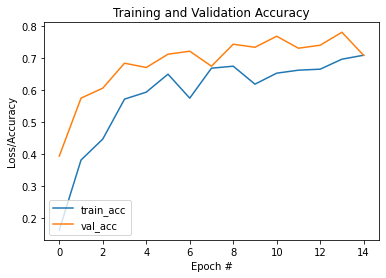

Saved model to disk


In [ ]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("evaluating after fine-tuning FC layers")
predIdxs = model_ft.predict(X_test)
predIdxs = np.argmax(predIdxs, axis=1)
ytest_values = np.argmax(Y_test, axis=1)
print(classification_report(ytest_values, predIdxs))

plt.figure()
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

model_json = model_ft.to_json()
with open("model_cnn_finetune.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_cnn_finetune.h5")
print("Saved model to disk")

## 2.2) Task 2: Semantic segmentation

In the classification task above, the goal is to predict 1 class label for each image, indicating which class is present in the image. On the contrary, for the semantic segmentation task, the goal is to predict **1 class label for each pixel** in the image, indicating to which class the pixel belongs. You don't only need to learn features to know which classes are present in the image, but you also need the information to locate and segment the objects in the image. This makes semantic segmentation a high-demanding task in computer vision, which has very practical applications (e.g. segmenting objects on the road for self-driving cars). 

We have chosen to perform class segmentation, as we are mostly interested in which classes are present in the images and where they are located. This means that as a result of segmentation, every class instance has to have the same color. On the other hand, with object segmentation you also want to make a distinction between objects of the same class (e.g. different people, cars etc.). We have decided to keep object segmentation out of the scope for this assignment.

This section covers the following parts: 

- Data processing
- Training from scratch, for unaugmented and augmented data
- Transfer learning

### 2.2.0) Data processing

In this part we are processing the data to the right formats so that it can be used for parts 2.2.1 (training from scratch) and 2.2.2 (transfer learning).

**Seperation of Already Segmented Images and Non-segmented Ones**

This part is used to seperate the images that have the segmented instance from the ones that don't have that version. This is needed because we can only train the segmentation model with the images of the PASCAL VOC dataset that also have a segmented version. 

For the **test_imgs** array, images dont have a segmented instance of itself.

For the **other_imgs** array, images have a segmented instance of itself.

In [ ]:
test_imgs = [] 
other_imgs = []
test_imgs_names = []
other_imgs_names = []

for i in range( len(org_img_names) ):

  len_str = len( org_img_names[i] )
  # Delete jpg since images in other folder uses the png version
  first_str = org_img_names[i][:len_str-3]

  # Ready the name to check if it exists in segmented image names array
  name = first_str + "png"

  # Store original images that are NOT segmented in test_imgs - these test_imgs 
  # Can be used as TEST images for segmentation task
  if name not in seg_cls_names:
    test_imgs.append( org_img[i] )
    test_imgs_names.append( org_img_names[i] )

  # Store original images that ARE segmented in other_imgs - these other_imgs 
  # Can be used as TRAINING and VALIDATION images for segmentation task
  else:
    other_imgs.append( org_img[i] )
    other_imgs_names.append( org_img_names[i] )

# Check how many images in test_imgs (6319, purely original) and other_imgs (1499, original+segmented)
print(len(test_imgs))
print(len(other_imgs))

6319
1499


We get a backup of the initially created arrays. 

In [ ]:
# Get a backup
originals = other_imgs.copy()
class_segmented = seg_cls.copy()
object_segmented = seg_obj.copy()

**Resizing Images in the Arrays**

Our general input format is to use 128x128 pixels with 3 color channels. Hence, it is important to first apply a preprocessing to our images.

However, we still want to keep the grayscale version of the resized images since models are also trainable with that version.

Finally, when resizing the images, the cv2.INTER_NEAREST option is used to prevent pixel value changes for the resized image as we only need 22 different classes for this segmentation task.

**CLASSES**

20 classes including people, planes, animals etc. - different colors

1 intermediary class - white

1 background - black

In [ ]:
# Length check for extracted image arrays

print( len(originals) )
print( len(class_segmented) )
print( len(object_segmented) )

# Resize the images to 128 by 128 pixels

resized_originals = []
resized_class = []
resized_object = []
resized_gray_originals = []

for i in range( len(originals) ):
  # Resizing the images and keep the pixel values (cv2.INTER_NEAREST)
  resized_org = cv2.resize( originals[i], (128,128), interpolation = cv2.INTER_NEAREST)
  resized_originals.append(resized_org)

  # Get the grayscale version
  gray_img = cv2.cvtColor(resized_org, cv2.COLOR_BGR2GRAY)
  resized_gray_originals.append(gray_img)

  resized_cls = cv2.resize( class_segmented[i], (128,128), interpolation = cv2.INTER_NEAREST)
  resized_class.append(resized_cls)

  resized_obj = cv2.resize( object_segmented[i], (128,128), interpolation = cv2.INTER_NEAREST)
  resized_object.append(resized_obj)

1499
1499
1499


Let's display an example of the original and resized images to see the difference.

Original Size of the Images


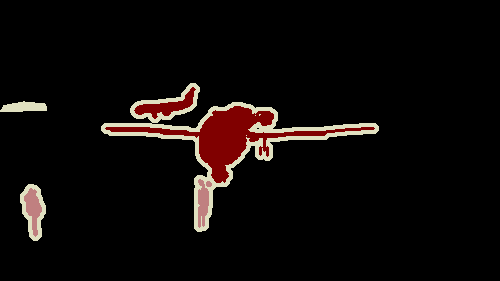

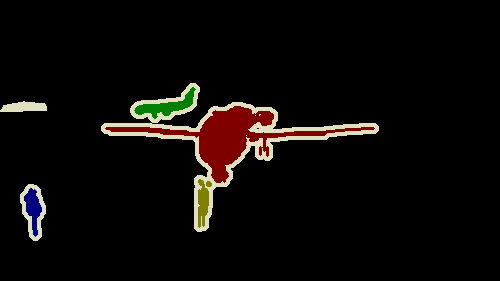

Resized version of the Images


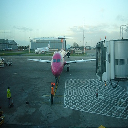

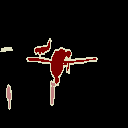

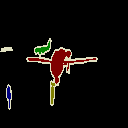

In [ ]:
# Show example of seg_cls

print("Original Size of the Images")
# seg_cls: each class has 1 color so no distinction between objects of same class 
cv2_imshow(seg_cls[0])

# Show example of seg_obj
# seg_obj: each object has different color, so objects of same class have different colors
# This is the difference with seg_cls!
cv2_imshow(seg_obj[0])

print("Resized version of the Images")
# Showing the example of resized images for segmented classes, segmented objects and original image
cv2_imshow( resized_originals[0] )
cv2_imshow( resized_class[0] )
cv2_imshow( resized_object[0] )

**Generating Necessary Functions to Convert Images to Masks with 22 Different Classes**

Several functions are created for different purposes:

- **create_classes**: Getting different unique pixel values from segmented images and add these values into a unique class array (22 classes with different pixel values).
- **create_mask_array**: We create a mask array containing only zeros and ones, with dimensions (Num Img, Num Col, Num Row, Num Classes) by using the segmented images and class pixel values (produced by previous function) as an input. This mask is the necessary format for the output when training the segmentation model. 
- **find_index**: Generated function for returning the index of a specific pixel value in a numpy array.
- **create_RGB_img**: Converting the predicted mask arrays into the segmented version of the images in order to visualize the results.

In [ ]:
def create_classes(dataset):
  # Getting the shape of our input
  (length, len_col, len_row, channel) = dataset.shape
  # Set an inital empty numpy array with a specific shape
  cls = np.array([]).reshape(0,3)

  # For every image
  for n_img in range(length):
    #print("Img",n_img)

    # Makes one long line of pixels
    flat_image = dataset[n_img].reshape(-1, 3)  

    # Returning an array of unique pixel value that are occuring in that image
    colors, counts = np.unique(flat_image, return_counts = True, axis=0)

    # Adding the pixel value if it is not present in the numpy array
    cls = np.concatenate((cls,colors), axis=0)
    cls = np.unique(cls, axis=0)

  return cls
def asvoid(arr):
    """View the array as dtype np.void (bytes)
    This collapses ND-arrays to 1D-arrays, so you can perform 1D operations on them.
    https://stackoverflow.com/a/16216866/190597 (Jaime)"""    
    arr = np.ascontiguousarray(arr)
    return arr.view(np.dtype((np.void, arr.dtype.itemsize * arr.shape[-1])))

def find_index(arr, x):
    arr_as1d = asvoid(arr)
    x = asvoid(x)
    return np.nonzero(arr_as1d == x)[0]

def create_mask_array(dataset,classes):
  # Getting the shape of our input
  (length, len_col, len_row, channel) = dataset.shape

  # Creating the empty mask with number of classes
  mask = np.zeros((length, len_col, len_row, len(classes))).astype('uint8')
  classes = classes.astype('uint8')

  # For every image
  for n_img in range(length):
    #print("img",n_img)      #Print in which image we ares

    # For every column and row
    for n_col in range(len_col):
      for n_row in range(len_row):

        # Get the pixel value from the classes index and set that index of mask corresponding to the class as 1
        pix_val = dataset[n_img][n_col][n_row]
        loc = find_index(classes, pix_val)

        mask[n_img][n_col][n_row][loc] = 1

  return mask

def create_rgb_img(masks,classes):
  # Getting the shape of our input
  (length, len_col, len_row, channel) = masks.shape
  results = np.zeros((length, len_col, len_row, 3)).astype('uint8')

  # For every image
  for n_img in range(length):
    #print("img", n_img)

    # For every row and column
    for n_col in range(len_col):
      for n_row in range(len_row):

        # Get the index of the value with max probability and set the pixel value of the predicted segment image as that value
        class_index = np.argmax(masks[n_img][n_col][n_row])
        results[n_img][n_col][n_row] = classes[class_index]

  return results

**Splitting the Segmented Images into Training, Validation and Test Set**

Then, we convert the resized images to numpy arrays and split the data set in a training (70%), validation (10%) and test (20%) set. 

We are also converting these arrays into Numpy Arrays to use them in the process of training.

In [ ]:
# use %70 for training, %10 for validation and %20 for test

# Get the ratio
ratio = len(resized_originals) // 10

# Generate the classes array
np_resized_class = np.array(resized_class)
classes = create_classes(np_resized_class)

print("Total classes:",len(classes))

# Split the dataset
gray_train_input = resized_gray_originals[:7*ratio]
train_input = resized_originals[:7*ratio]
train_result = resized_class[:7*ratio]

gray_valid_input = resized_gray_originals[7*ratio:8*ratio]
valid_input = resized_originals[7*ratio:8*ratio]
valid_result = resized_class[7*ratio:8*ratio]

gray_test_input = resized_gray_originals[8*ratio:len(originals)]
test_input = resized_originals[8*ratio:len(originals)]
test_result = resized_class[8*ratio:len(originals)]

# ---------------------------------------------------------

# Convert the splitted arrays into numpy arrays
np_gray_train_input = np.array(gray_train_input)
np_train_input = np.array(train_input)
np_train_result = np.array(train_result)

np_gray_valid_input = np.array(gray_valid_input)
np_valid_input = np.array(valid_input)
np_valid_result = np.array(valid_result)

np_gray_test_input = np.array(gray_test_input)
np_test_input = np.array(test_input)
np_test_result = np.array(test_result)


# Generate the mask arrays for training and validation dataset
train_mask = create_mask_array(np_train_result,classes)
print("Train mask is generated!")
valid_mask = create_mask_array(np_valid_result,classes)
print("Validation mask is generated!")

Total classes: 22
Train mask is generated!
Validation mask is generated!


**Function Checking** 

Let's check the credibility of the generated functions in the earlier part.

These tests show that the created functions are working properly.

Array that stores the class pixel values
(22, 3)
Array that stores the 2 of the mask values
(2, 128, 128, 22)
Recreated Images wit Create RGB Img


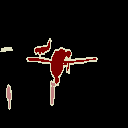

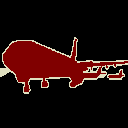

Original Segmented Picture


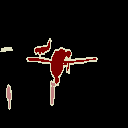

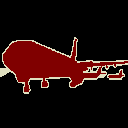

In [ ]:
# create_classes check

print("Array that stores the class pixel values")
print(classes.shape) 

print("Array that stores the 2 of the mask values")
check = np.array([train_mask[0],train_mask[1]])
print(check.shape) 

# create_rgb check
res_check = create_rgb_img(check,classes)

print("Recreated Images wit Create RGB Img")
cv2_imshow(res_check[0])
cv2_imshow(res_check[1])

print("Original Segmented Picture")
cv2_imshow(np_train_result[0])
cv2_imshow(np_train_result[1])

### 2.2.1) From scratch

In this part the segmentation model will be trained from scratch. The ultimate goal is to train a model that is able to segment new images, which means returning the right contours for the objects, together with the right classification (color of the segmentation image) for each pixel in the image. 

#### Unaugmented data

We will first perform the model training without augmenting the data. 

For this task, the 'segmentation_models' library of Keras will be used. We will use the Unet architecture as it is considered to perform well for the segmentation of images. The Unet architecture allows to work with skip connections, which are useful to connect the encoder and decoder part with each other in order to let the decoder access the low-level features produced by the encoder layers. This is required for creating accurate boundaries around the segmented objects. 

For the building, compiling and training of the Unet below, we used the following parameters: 

- Backbone (classification model that is behind the encoder of the Unet): resnet50
- Classes: 22 (20 object classes, 1 background class, 1 border class)
- Input_shape: (128,128,3), as we resized the images to these dimensions before
- Activation function of the last model layer: softmax, which turns numbers aka logits into probabilities that sum to one. With the softmax activation function we make sure that our predictions for each pixel are probabilities that sum to one. 
- Optimizer: Adam, this is considered one of the best-practice optimizers in deep learning. 
- Loss function: categorical focal loss, between the ground truth and the prediction. The focal loss function is beneficial when the dataset is imbalanced, which is the case in this assignment. There is a clear imbalance between foreground and background classes, where the background pixels count for about 70-75% of all pixels. Imbalanced datasets have two drawbacks: 
  - Training is inefficient as most samples are easy examples that contribute no useful learning signal;
  - The easy examples can overwhelm training and lead to degenerate models.

Class imbalance is addressed by the focal loss function by down-weighting inliers (easy examples) in order to make their contribution to the total loss small even if there are a lot of easy examples (here: background pixels) 

(source: https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/)

- metrics: F-score, which corresponds to the Dice coefficient. This score reaches its best value at 1 and its worst value at 0.

**Importing Necessary Libraries for Model Creation**

In [ ]:
import tensorflow as tf
from skimage.io import imread, imshow
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import keras
#from keras import backend as keras
import cv2
from keras.regularizers import l2
!pip install -U segmentation-models
import segmentation_models as sm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

Segmentation Models: using `keras` framework.


**Generation and Training of the Model Using the Library and Earlier Functions**

In [ ]:
# Create the backbone of our model
BACKBONE = 'resnet50'

# Give the important parameters such as input shape and activation function
n_model = sm.Unet(BACKBONE, classes=22, input_shape=(128, 128, 3), activation='softmax', encoder_weights=None)

preprocess_input = sm.get_preprocessing(BACKBONE)

# Preprocess the given inputs
processed_trx = preprocess_input(np_train_input)
processed_vlx = preprocess_input(np_valid_input)

# Choose the optimizer for the fitting process
optim = keras.optimizers.Adam(0.001)

# Choose the loss category
focal_loss = sm.losses.CategoricalFocalLoss()

# Compile the Model
n_model.compile(optim, loss=focal_loss, metrics=[sm.metrics.f1_score])

For the segmentation models, it took a substantial amount of time (more than 1 hour) to fully train the models. To avoid that you need to run our notebook for such a long time, we would like to ask you to upload the h5 files (with the weights) to the files of this colab notebook via the sidebar on the left. We will indicate clearly which h5 files need to be uploaded and when this needs to be done. 

For the first model (from scratch without data augmentation) we would like to ask you to upload the file 'best_model.h5' that we included in the deliverables for this project. When the h5 file is uploaded correctly, please set the path of this file accordingly in the next code cell. 

In [ ]:
# Load the weights
n_model.load_weights('/content/best_model.h5')

The next code cell is put between comments because it contains the training statement for our model. This does not need to be done anymore, as we loaded the weights in the model in the previous code cell. This is also done for the other 2 models (from scratch with data augmentation + transfer learning). 

In [ ]:
''' 
callbacks = [keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),]

history_scratch = n_model.fit(x=processed_trx,y=train_mask,batch_size=16,epochs=100,verbose=1,validation_data=(processed_vlx,valid_mask),callbacks=callbacks,shuffle=True)
'''

" \ncallbacks = [keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),]\n\nhistory_scratch = n_model.fit(x=processed_trx,y=train_mask,batch_size=16,epochs=100,verbose=1,validation_data=(processed_vlx,valid_mask),callbacks=callbacks,shuffle=True)\n"

**Plot the Learning Curve for the Focal Loss**

On this plot we can see that the training converged very quickly (after about 20-30 epochs). We can see that the loss on the training set is still decreasing very slowly, but that the loss on the validation set has not been improved after epoch 20-30.

![image1](https://drive.google.com/uc?id=1v25t0yjsq44BXODbrBw91WZlOA80qawd)

The following code cell is also put between comments, because the 'history' object is not generated. However, we wanted to include this code to show how the above plot was generated. This is also done for the other 2 models (from scratch with data augmentation + transfer learning). 

In [ ]:
'''
# Plot history: focal_loss

plt.plot(history_scratch.history['loss'], label='Focal loss (training data)')
plt.plot(history_scratch.history['val_loss'], label='Focal loss (validation data)')
plt.title('Learning curve - Focal loss')
plt.ylabel('Focal loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()
'''

'\n# Plot history: focal_loss\n\nplt.plot(history_scratch.history[\'loss\'], label=\'Focal loss (training data)\')\nplt.plot(history_scratch.history[\'val_loss\'], label=\'Focal loss (validation data)\')\nplt.title(\'Learning curve - Focal loss\')\nplt.ylabel(\'Focal loss value\')\nplt.xlabel(\'No. epoch\')\nplt.legend(loc="upper right")\nplt.show()\n'

**Plot the Learning Curve for the F-score**

On this plot we see a similar result as in the one above. The F-score for the training set seems to be increasing further, but the F-score for the validatation set converges already after 30-40 epochs to a value in the range 0.08-0.10. This is a typical plot for overfitting, where the performance on the training data is still increasing but converged already on the validation set. 

![image2](https://drive.google.com/uc?id=1WFqs2ICmZzv_y-aQAhesLIavFhPDDi1w)

The following code cell is also put between comments, because the 'history' object is not generated. However, we wanted to include this code to show how the above plot was generated. This is also done for the other 2 models (from scratch with data augmentation + transfer learning). 

In [ ]:
'''
# Plot history: f1_score 

plt.plot(history_scratch.history['f1-score'], label='F-score (training data)')
plt.plot(history_scratch.history['val_f1-score'], label='F-score (validation data)')
plt.title('Learning curve - Fscore')
plt.ylabel('F-score')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
'''

'\n# Plot history: f1_score \n\nplt.plot(history_scratch.history[\'f1-score\'], label=\'F-score (training data)\')\nplt.plot(history_scratch.history[\'val_f1-score\'], label=\'F-score (validation data)\')\nplt.title(\'Learning curve - Fscore\')\nplt.ylabel(\'F-score\')\nplt.xlabel(\'No. epoch\')\nplt.legend(loc="upper left")\nplt.show()\n'

**Predict the Results as a Mask Array & Visualize the Results**

We vizualized the results for the first 20 test images using a figure with 3 columns:
- column 1: original image
- column 2: ground truth segmentation
- column 3: predictions

In this figure we can see that the model trained from scratch and without data augmentation is performing quite badly. There are some images where the contours are found by the model, but the predicted classes are completely wrong. For example, in image 17 (a car), the contours are found quite well, but the model predicts light green (sofa) and cyan (bus). However, the trained model is generally not able to segment the objects in the images and assign the right classes to them. Therefore we will try to improve the model by using data augmentation in the next part. 

307/307 [==============================] - 3s 10ms/step


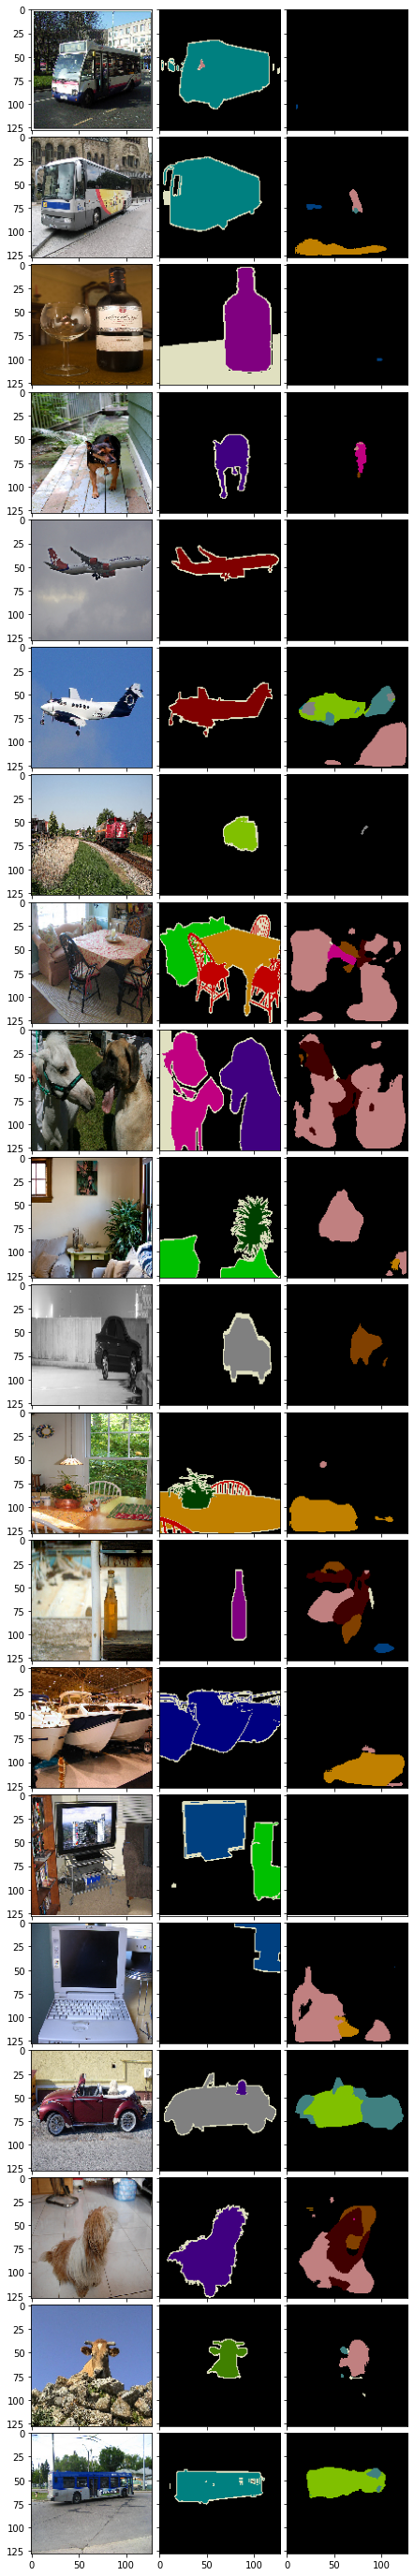

In [ ]:
# Preprocess the given input
processed_tex = preprocess_input(np_test_input)

# Predict the test images
test_mask_scratch = n_model.predict(processed_tex, batch_size = 16, verbose = 1)

# Convert the predicted mask array into rgb format
ress_scratch = create_rgb_img(test_mask_scratch,classes)

# plot the original images (column 1), ground truth segmentation (column 2) and predictions (column 3) for the test set
fig = plt.figure(figsize=(50, 50))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(20, 3),  # creates Nx3 grid of axes
                  axes_pad=0.1,  # pad between axes in inch.
                  )
for i in range(20):
  grid[i*3].imshow(cv2.cvtColor(np_test_input[i], cv2.COLOR_BGR2RGB))
  grid[i*3+1].imshow(cv2.cvtColor(np_test_result[i], cv2.COLOR_BGR2RGB))
  grid[i*3+2].imshow(cv2.cvtColor(ress_scratch[i], cv2.COLOR_BGR2RGB))

**Calculate Dice score on the Test Set**

In the code below, the Dice score for the segmentation of the test set is calculated. The Dice score is often used to evaluate semantic segmentation models. It is calculated as two times the intersection area of the ground truth and predictions divided by the total number of pixels in both images. It is not only a measure for the number of true positives that you find, but it also penalizes for the false positives that are predicted. In this sense, the Dice score is more similar to precision than to accuracy. 

For the model trained from scratch without augmenting the data, a Dice score of 0.696 is found. We will check in the next part whether the Dice score can be increased by using augmented data. 

In [ ]:
def dice(im1, im2):
    
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

test_mask=create_mask_array(np_test_result,classes)
ress_scratch_mask=create_mask_array(ress_scratch,classes)

score=dice(test_mask,ress_scratch_mask)
print(score)


0.6962568550234121


#### Augmented data

We will now augment the data in order to improve the model performance. Like in our classification section, we will augment the training data (original and segmented images) in the following ways: 

- Flipping the image
- Rotating the image 90 degrees
- Increasing the brightness of the image
- Increasing the saturation of the image 

We add all these seperate augmentations to our training set alongside the original images.

In [ ]:
# data augmentation

train_input_flipped=[]
train_result_flipped=[]
train_input_rotated=[]
train_result_rotated=[]
train_input_bright=[]
train_result_bright=np_train_result
train_input_satur=[]
train_result_satur=np_train_result

for i in range(len(np_train_input)):

  # flipping
  flipped_image = cv2.flip(np_train_input[i], 1)
  flipped_segm = cv2.flip(np_train_result[i], 1)
  train_input_flipped.append(flipped_image)
  train_result_flipped.append(flipped_segm)

  # rotating
  transposed_img = cv2.transpose(np_train_input[i])
  transposed_segm = cv2.transpose(np_train_result[i])
  rotated_img = cv2.flip(transposed_img, flipCode=0)
  rotated_segm = cv2.flip(transposed_segm, flipCode=0)
  rotated_img = cv2.flip(rotated_img, 2)
  rotated_segm = cv2.flip(rotated_segm, 2)
  train_input_rotated.append(rotated_img)
  train_result_rotated.append(rotated_segm)

  # increasing brightness
  bright_image = tf.image.adjust_brightness(np_train_input[i], 0.4)
  bright_image = bright_image.numpy()
  train_input_bright.append(bright_image)

  # increasing saturation
  satur_image = tf.image.adjust_saturation(np_train_input[i], 3)
  satur_image=satur_image.numpy()
  train_input_satur.append(satur_image)

# convert to numpy arrays
np_train_input_flipped = np.array(train_input_flipped)
np_train_input_rotated = np.array(train_input_rotated)
np_train_input_bright = np.array(train_input_bright)
np_train_input_satur = np.array(train_input_satur)
np_train_result_flipped = np.array(train_result_flipped)
np_train_result_rotated = np.array(train_result_rotated)

# create masks 

train_mask_flipped = create_mask_array(np_train_result_flipped,classes)
train_mask_rotated = create_mask_array(np_train_result_rotated,classes)
train_mask_bright = train_mask
train_mask_satur = train_mask 

In [ ]:
# create augmented training set
np_train_input_augm = np.concatenate((np_train_input,np_train_input_flipped,np_train_input_rotated,np_train_input_bright,np_train_input_satur), axis=0)
train_mask_augm = np.concatenate((train_mask,train_mask_flipped,train_mask_rotated,train_mask_bright,train_mask_satur))

We can now use the augmented dataset to train the model again from scratch. The code below is an exact copy of the code used for the first training from scratch, but now with the augmented dataset. This means that we used the same activation function, loss function, number of epochs etc. The only difference is that we used a batch-size of 64 instead of 16 for computation reasons. 



In [ ]:
# Create the backbone of our model
BACKBONE = 'resnet50'

# Give the important parameters such as input shape and activation function
n_model_augm = sm.Unet(BACKBONE, classes=22, input_shape=(128, 128, 3), activation='softmax', encoder_weights=None)

preprocess_input = sm.get_preprocessing(BACKBONE)

# Preprocess the given inputs
processed_trx_augm = preprocess_input(np_train_input_augm)
processed_vlx = preprocess_input(np_valid_input)

# Choose the optimizer for the fitting process
optim = keras.optimizers.Adam(0.001)

# Choose the loss category
focal_loss = sm.losses.CategoricalFocalLoss()

# Compile the Model
n_model_augm.compile(optim, loss=focal_loss, metrics=[sm.metrics.f1_score])

For the second model (from scratch with data augmentation) we would like to ask you to upload the file 'best_model_augmented.h5' that we included in the deliverables for this project. When the h5 file is uploaded correctly, please set the path of this file accordingly in the next code cell. 

In [ ]:
# Load the weights
n_model_augm.load_weights('/content/best_model_augmented.h5')

In [ ]:
''' 
callbacks = [keras.callbacks.ModelCheckpoint('./best_model_augmented.h5', save_weights_only=True, save_best_only=True, mode='min'),]

history_scratch_augm = n_model_augm.fit(x=processed_trx_augm,y=train_mask_augm,batch_size=64,epochs=100,verbose=1,validation_data=(processed_vlx,valid_mask),callbacks=callbacks,shuffle=True)
'''

" \ncallbacks = [keras.callbacks.ModelCheckpoint('./best_model_augmented.h5', save_weights_only=True, save_best_only=True, mode='min'),]\n\nhistory_scratch_augm = n_model_augm.fit(x=processed_trx_augm,y=train_mask_augm,batch_size=64,epochs=100,verbose=1,validation_data=(processed_vlx,valid_mask),callbacks=callbacks,shuffle=True)\n"

**Plot the Learning Curve for the Focal Loss**

The pattern in this learning curve is highly similar to the model learned with non-augmented data. The loss on the training set is slightly decreasing further, but the loss on the validation set already converges after 20-30 epochs, and even increases in some iterations. This plot indicates that training the model for a longer period would not result in better performance. 

![image3](https://drive.google.com/uc?id=1-NtecuCiZ6y0jpKpvWAJMzkWZo8k_Wnr)

In [ ]:
'''
# Plot history: focal_loss

plt.plot(history_scratch_augm.history['loss'], label='Focal loss (training data)')
plt.plot(history_scratch_augm.history['val_loss'], label='Focal loss (validation data)')
plt.title('Learning curve - Focal loss')
plt.ylabel('Focal loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()
'''

'\n# Plot history: focal_loss\n\nplt.plot(history_scratch_augm.history[\'loss\'], label=\'Focal loss (training data)\')\nplt.plot(history_scratch_augm.history[\'val_loss\'], label=\'Focal loss (validation data)\')\nplt.title(\'Learning curve - Focal loss\')\nplt.ylabel(\'Focal loss value\')\nplt.xlabel(\'No. epoch\')\nplt.legend(loc="upper right")\nplt.show()\n'

**Plot the Learning Curve for the F-score**

In this plot we see that the F-score on the validation set is slightly higher than with the non-augmented data, ranging between 0.13-0.16 (this was in the range 0.08-0.10 with the non-augmented data). This indicates that augmenting the data might have a slightly positive effect on the performance. However, we must admit that an F-score between 0.13 and 0.16 is still not a sign of good performance, if you know that this score varies between 0 and 1. 

![image4](https://drive.google.com/uc?id=1dzdqh7wy1Jsvcmc3AvBp1-bFn3FeFnMP)

In [ ]:
'''
# Plot history: f1_score

plt.plot(history_scratch_augm.history['f1-score'], label='F-score (training data)')
plt.plot(history_scratch_augm.history['val_f1-score'], label='F-score (validation data)')
plt.title('Learning curve - F-score')
plt.ylabel('F-score')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
'''

'\n# Plot history: f1_score\n\nplt.plot(history_scratch_augm.history[\'f1-score\'], label=\'F-score (training data)\')\nplt.plot(history_scratch_augm.history[\'val_f1-score\'], label=\'F-score (validation data)\')\nplt.title(\'Learning curve - F-score\')\nplt.ylabel(\'F-score\')\nplt.xlabel(\'No. epoch\')\nplt.legend(loc="upper left")\nplt.show()\n'

**Predict the Results as a Mask Array & Visualize the Results**

The figure below contains the following columns: 

- column 1: original image
- column 2: ground truth segmentation
- column 3: predictions with unaugmented data
- column 4: predictions with augmented data


This figure confirms that the model learned with the augmented data still does not perform very well for the segmentation task. In general, images containing more than 1 object or class seem to be the most difficult to segment. However, for some images we can see some improvement compared to the model for the non-augmented data. For example, image 6 (a plane) is segmented almost perfectly, but it is still not classified fully with the color red (plane). Hence, we can say that augmenting the data might improve some results, but still does not enable us to segment the images accurately. 

In the next part we will investigate whether a pre-trained model might improve the segmentation performance. 



307/307 [==============================] - 2s 8ms/step


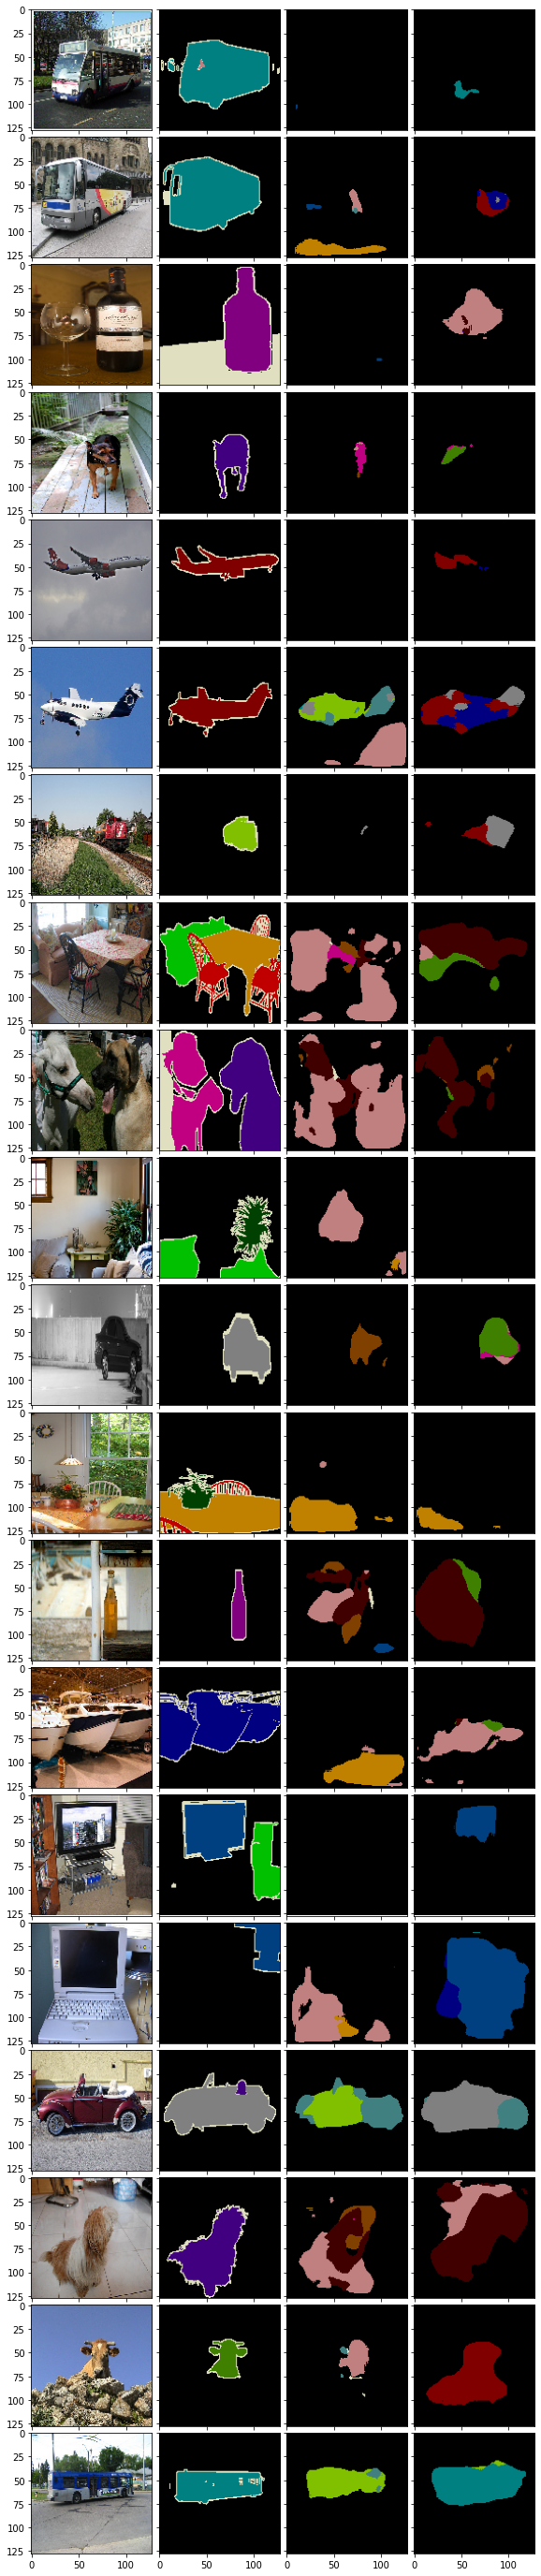

In [ ]:
# Preprocess the given input
processed_tex = preprocess_input(np_test_input)

# Predict the test images
test_mask_scratch_augm = n_model_augm.predict(processed_tex, batch_size = 16, verbose = 1)

# Convert the predicted mask array into rgb format
ress_scratch_augm = create_rgb_img(test_mask_scratch_augm,classes)

# plot the original images (column 1), ground truth segmentation (column 2), predictions with and without augmentation (column 3 and 4) for the test set
fig = plt.figure(figsize=(50, 50))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(20, 4),  # creates Nx3 grid of axes
                  axes_pad=0.1,  # pad between axes in inch.
                  )
for i in range(20):
  grid[i*4].imshow(cv2.cvtColor(np_test_input[i], cv2.COLOR_BGR2RGB))
  grid[i*4+1].imshow(cv2.cvtColor(np_test_result[i], cv2.COLOR_BGR2RGB))
  grid[i*4+2].imshow(cv2.cvtColor(ress_scratch[i], cv2.COLOR_BGR2RGB))
  grid[i*4+3].imshow(cv2.cvtColor(ress_scratch_augm[i], cv2.COLOR_BGR2RGB))

**Calculate Dice score on the Test Set**

With the augmented dataset, the Dice score on the test set is 0.725, which is a small increase compared to the 0.696 with the unaugmented dataset. In the next part we will check if the Dice score can be increased further by using a pre-trained model. 

In [ ]:
ress_scratch_aug_mask=create_mask_array(ress_scratch_augm,classes)

score=dice(test_mask,ress_scratch_aug_mask)
print(score)

0.7250463628613599


### 2.2.2) Transfer Learning and Fine-tuning

In this part we will use a Unet that is pre-trained on the Imagenet dataset and further fine-tune it for our dataset. For this purpose, we can use the same Keras library as before, where we only need to set the 'encoder_weights' parameter to 'imagenet' in order to have a Unet that is pre-trained on the well-known ImageNet dataset. The advantage here is that we can use the pre-trained features of the ImageNet dataset as starting point for fine-tuning the weights to our PASCAL VOC dataset. 

In the code below we fine-tune the pre-trained Unet model by using the non-augmented data in order to investigate the effect of pre-training as purely as possible. 

**Generation and Training of the Transfer Learning Model Using the Library and Earlier Functions**

In [ ]:
# Create the backbone of our model
BACKBONE = 'resnet50'

# Give the important parameters such as input shape and activation function
# pre-trained weights: encoder_weights='imagenet'
transfer_model = sm.Unet(BACKBONE, classes=22, input_shape=(128, 128, 3), activation='softmax', encoder_weights='imagenet')

preprocess_input = sm.get_preprocessing(BACKBONE)

# Preprocess the given inputs
processed_trx = preprocess_input(np_train_input)
processed_vlx = preprocess_input(np_valid_input)

# Choose the optimizer for the fitting process
optim = keras.optimizers.Adam(0.0001)

# Choose the loss category
focal_loss = sm.losses.CategoricalFocalLoss()

# Compile the Model
transfer_model.compile(optim, loss=focal_loss, metrics=[sm.metrics.f1_score])

94593024/94592056 [==============================] - 1s 0us/step


For the third model (transfer learning) we would like to ask you to upload the file 'best_model_transfer.h5' that we included in the deliverables for this project. When the h5 file is uploaded correctly, please set the path of this file accordingly in the next code cell. 

In [ ]:
# Load the weights
transfer_model.load_weights('/content/best_model_transfer.h5')

In [ ]:
''' 
callbacks = [keras.callbacks.ModelCheckpoint('./best_model_transfer.h5', save_weights_only=True, save_best_only=True, mode='min'),]

history_transfer = transfer_model.fit(x=processed_trx,y=train_mask,batch_size=16,epochs=100,verbose=1,validation_data=(processed_vlx,valid_mask),callbacks=callbacks,shuffle=True)
'''

" \ncallbacks = [keras.callbacks.ModelCheckpoint('./best_model_transfer.h5', save_weights_only=True, save_best_only=True, mode='min'),]\n\nhistory_transfer = transfer_model.fit(x=processed_trx,y=train_mask,batch_size=16,epochs=100,verbose=1,validation_data=(processed_vlx,valid_mask),callbacks=callbacks,shuffle=True)\n"

**Plot the Learning Curve for the Focal Loss**

The learning curve for the focal loss looks similar to the previous ones. 

![image5](https://drive.google.com/uc?id=1gK18Nvo-2IqS5n_wo3L5JganZyZDlczx)

In [ ]:
'''
# Plot history: focal_loss

plt.plot(history_transfer.history['loss'], label='Focal loss (training data)')
plt.plot(history_transfer.history['val_loss'], label='Focal loss (validation data)')
plt.title('Learning curve - Focal loss')
plt.ylabel('Focal loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()
'''

'\n# Plot history: focal_loss\n\nplt.plot(history_transfer.history[\'loss\'], label=\'Focal loss (training data)\')\nplt.plot(history_transfer.history[\'val_loss\'], label=\'Focal loss (validation data)\')\nplt.title(\'Learning curve - Focal loss\')\nplt.ylabel(\'Focal loss value\')\nplt.xlabel(\'No. epoch\')\nplt.legend(loc="upper right")\nplt.show()\n'

**Plot the Learning Curve for the Dice Score Coefficient**

We see that the F-score for the validation set further increased compared with the models trained from scratch. Now the F-score is ranging between 0.19 and 0.23, and even seems to be increasing further. 

![image6](https://drive.google.com/uc?id=1fDPTW4AEr0Rkmiih25krsqYncfHyB-AI)

In [ ]:
'''
# Plot history: f1_score

plt.plot(history_transfer.history['f1-score'], label='F-score (training data)')
plt.plot(history_transfer.history['val_f1-score'], label='F-score (validation data)')
plt.title('Learning curve - F-score')
plt.ylabel('F-score')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
'''

'\n# Plot history: f1_score\n\nplt.plot(history_transfer.history[\'f1-score\'], label=\'F-score (training data)\')\nplt.plot(history_transfer.history[\'val_f1-score\'], label=\'F-score (validation data)\')\nplt.title(\'Learning curve - F-score\')\nplt.ylabel(\'F-score\')\nplt.xlabel(\'No. epoch\')\nplt.legend(loc="upper left")\nplt.show()\n'

**Predict the Results as a Mask Array & Visualize the Results**

The images in the figure below are:

- column 1: original image
- column 2: ground truth segmentation
- column 3: prediction by model with augmented data
- column 4: prediction by pre-trained model

We can see that the pre-trained model is performing better than the two previous ones. Certainly for the images containing only 1 object (e.g. 1 plane, 1 bus), the predictions sometimes approximate the ground truth segmentation even perfectly (e.g. the busses in images 1 and 2, the planes in images 5 and 6). The worst segmentation results are still for the images containing several objects. 

307/307 [==============================] - 2s 8ms/step


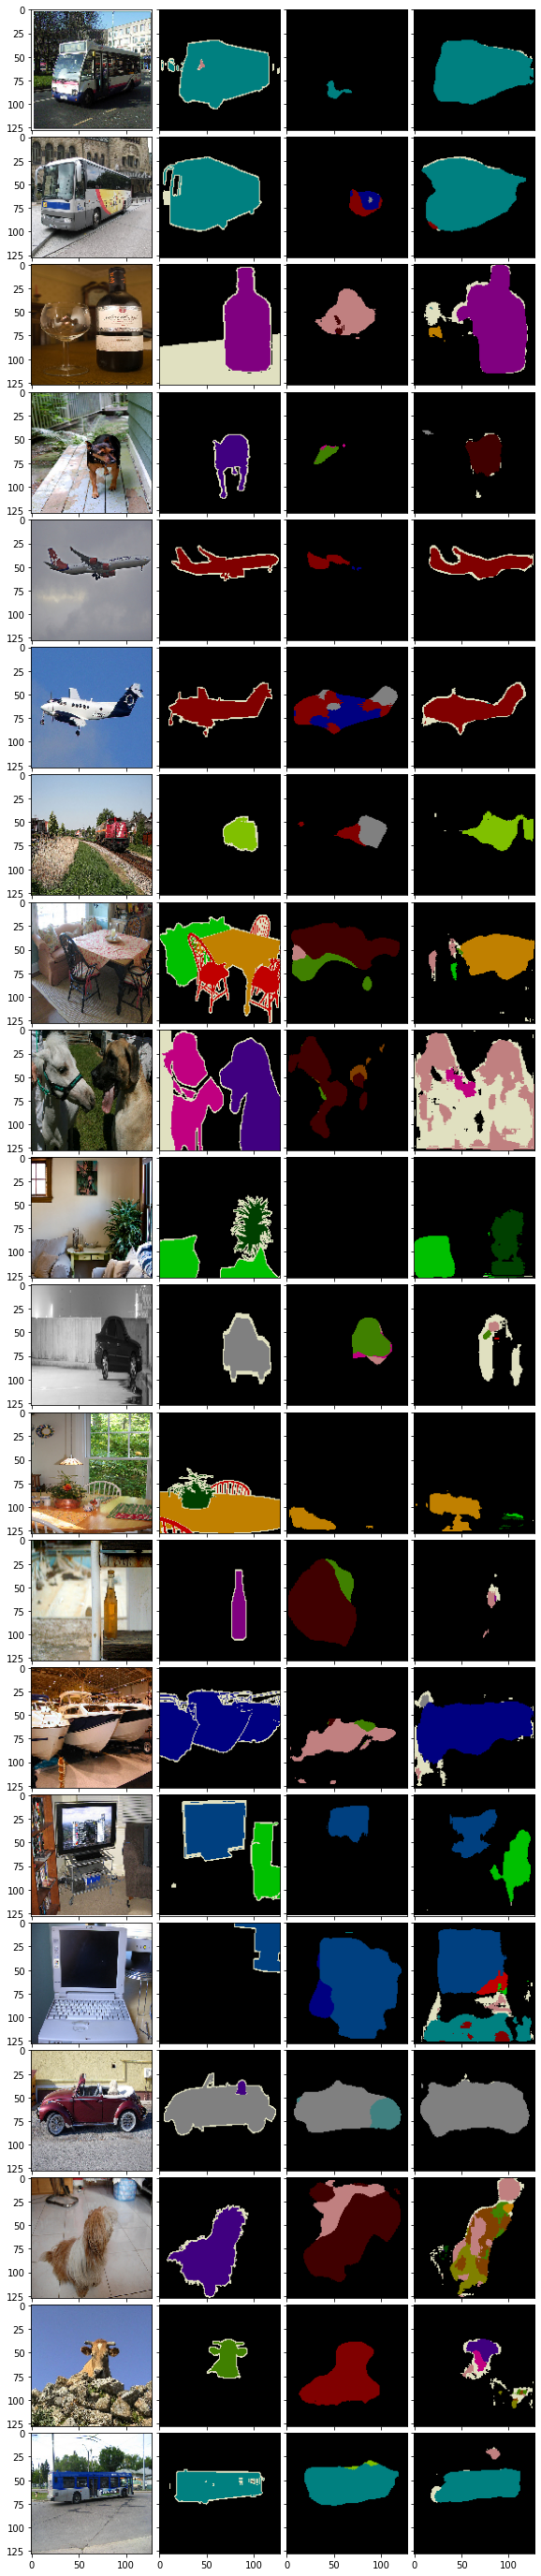

In [ ]:
# Preprocess the given input
processed_tex = preprocess_input(np_test_input)

# Predict the test images
test_mask_transfer = transfer_model.predict(processed_tex, batch_size = 16, verbose = 1)

# Convert the predicted mask array into rgb format
ress_transfer = create_rgb_img(test_mask_transfer,classes)

# compare the results with the training from scratch 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(50, 50))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(20, 4),  # creates Nx4 grid of axes
                  axes_pad=0.1,  # pad between axes in inch.
                  )
for i in range(20):
  grid[i*4].imshow(cv2.cvtColor(np_test_input[i], cv2.COLOR_BGR2RGB))
  grid[i*4+1].imshow(cv2.cvtColor(np_test_result[i], cv2.COLOR_BGR2RGB))
  grid[i*4+2].imshow(cv2.cvtColor(ress_scratch_augm[i], cv2.COLOR_BGR2RGB))
  grid[i*4+3].imshow(cv2.cvtColor(ress_transfer[i], cv2.COLOR_BGR2RGB))

**Calculate Dice score on the Test Set**

The Dice score on the test set is now 0.817, which is a significant increase compared to the previous models (Dice scores of 0.696 and 0.725). This shows that using a pre-trained model might be very beneficial in order to segment the images more accurately. 

In [ ]:
ress_transfer_mask=create_mask_array(ress_transfer,classes)

score=dice(test_mask,ress_transfer_mask)
print(score)

0.8169511925514047


# 3) Assignment 2: Adversarial examples

In this section we connect an encoder-decoder network to our original classifier. By purposefully mislabelling one class and training on these false labels, the encoder-decoder network can come up with pertubations of the original image that will allow it to be misclassified. In doing this we can effectively fool our network. In the following demonstration we will be attempting to fool our classifier into labelling images of cows as buses.


We start by extracting the cow images and labels for our train, validation, and test data

In [ ]:
train_labels_cow =   [index for index, x in enumerate(train_labels) if x == classes_classification.index('cow')]
valid_labels_cow =   [index for index, x in enumerate(val_labels) if x == classes_classification.index('cow')]
test_labels_cow =   [index for index, x in enumerate(test_labels) if x == classes_classification.index('cow')]

train_images_cow = [train_images[i] for i in train_labels_cow]
train_images_array_cow = np.asarray(train_images_cow)

valid_images_cow = [val_images[i] for i in valid_labels_cow]
valid_images_array_cow = np.asarray(valid_images_cow)

test_images_cow = [test_images[i] for i in test_labels_cow]
test_images_array_cow = np.asarray(test_images_cow)

Before we train our autoencoder, we re-define the training data. The training images are the same as we fed the original classifier in section 2.1

However, we are looking to fool our classifier. In this example we will be changing the labeling of all cow images from "cow" to "bus".

In [ ]:
false_train_label = [x if x != classes_classification.index('cow') else classes_classification.index('bus') for x in train_labels]
false_val_labels = [x if x != classes_classification.index('cow') else classes_classification.index('bus') for x in val_labels]
false_test_labels = [x if x != classes_classification.index('cow') else classes_classification.index('bus') for x in test_labels]

false_train_labels_array = np.array(false_train_label)
false_valid_labels_array = np.array(false_val_labels)
false_test_labels_array = np.array(false_test_labels)
train_images_array = np.array(train_images)
valid_images_array = np.array(val_images)

X_train = train_images_array
Y_train = np_utils.to_categorical(false_train_labels_array, 20)
X_valid = valid_images_array
Y_valid = np_utils.to_categorical(false_valid_labels_array, 20)

Model 1 - Our first model will be trained on the same training images used for our original classifier.

Here we implement our encoder-decoder network. The network compresses 128x128x3 images into a flattened array of length 128. The info in this flattened array is then used to reconstruct the original images. By training this network we learn how to minimize reconstruction error, making the images look as similar as possible to the original. 

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Add

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

IMG_SHAPE = train_images_array_cow.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 128)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = Model(inp,reconstruction)


We then connect this encoder-decoder network to our original classifier with an add layer. By minimizing the categorical cross entropy of the training images and the false labels, the autoencoder learns small perturbations which when added to the original images will cause the cow images to be labelled as bus images. We chose gradient descent with a small learning rate as we want minimal perturbations, making the addition of the perturbation imperceptible to the naked eye. Additionally, we freeze the layers of the original classifier so only changes in the encoder-decoder function will increase accuracy.


In [ ]:
# load the VGG16 network leaving off the FC layers
baseModel = autoencoder
# construct new fully connected layers
headModel = baseModel.output
headModel = Add()([headModel, inp])
headModel = model_ft(headModel)
# place the new fully connected layers on top of the base VGG model
model = Model(inputs=baseModel.input, outputs=headModel)

headModel.trainable = False

# set learning rate and loss function
opt = SGD(lr=2e-4, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt,
	metrics=["accuracy"])

history = model.fit(x=X_train, y=Y_train, epochs=10, validation_data=(X_val, Y_val), batch_size=128)

Train on 5472 samples, validate on 1564 samples
Epoch 1/10
5472/5472 [==============================] - 13s 2ms/step - loss: 2.8056 - accuracy: 0.7065 - val_loss: 2.3686 - val_accuracy: 0.7014
Epoch 2/10
5472/5472 [==============================] - 10s 2ms/step - loss: 1.5746 - accuracy: 0.7474 - val_loss: 1.9742 - val_accuracy: 0.7257
Epoch 3/10
5472/5472 [==============================] - 10s 2ms/step - loss: 0.9863 - accuracy: 0.8008 - val_loss: 2.0027 - val_accuracy: 0.7276
Epoch 4/10
5472/5472 [==============================] - 10s 2ms/step - loss: 0.6809 - accuracy: 0.8408 - val_loss: 1.8673 - val_accuracy: 0.7442
Epoch 5/10
5472/5472 [==============================] - 10s 2ms/step - loss: 0.5062 - accuracy: 0.8734 - val_loss: 1.8775 - val_accuracy: 0.7327
Epoch 6/10
5472/5472 [==============================] - 10s 2ms/step - loss: 0.3995 - accuracy: 0.8894 - val_loss: 1.9100 - val_accuracy: 0.7410
Epoch 7/10
5472/5472 [==============================] - 10s 2ms/step - loss: 0.356

Here we visualize our perturbations. The perturbations are so slight that they simply look black to our naked eye. We scale the perturbations up and see that they appear as seemingly random noise.

When perturbations are added to the original image, the resulting image looks almost exactly like the original. This is the goal, as it is key to fool the classifier


Original Image


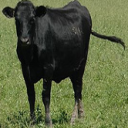

Perturbation


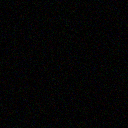

Scaled Perturbation


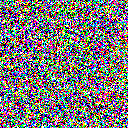

Original Image + Perturbation


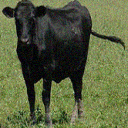

In [ ]:
perturbed_cow_labels_test = [classes_classification.index('bus')] * len(test_images_array_cow)
X_test = test_images_array_cow
Y_test = np_utils.to_categorical(perturbed_cow_labels_test, 20)


layer_outputs = [baseModel.output] 
activation_model = Model(inputs=model.input, outputs=layer_outputs) 
activations = activation_model.predict(X_test)
perturbation_image1 = activations[0]
print("Original Image")
cv2_imshow(X_test[0])
print("Perturbation")
cv2_imshow(perturbation_image1)
print("Scaled Perturbation")
cv2_imshow(perturbation_image1*256)
print("Original Image + Perturbation")
cv2_imshow(X_test[0]+perturbation_image1)

We then make predictions using our test data. Although the adversial attack is not perfect, we still got the model to predict cow images as buses about half of the time

In [ ]:
predIdxs = model.predict(X_test)
predIdxs = np.argmax(predIdxs, axis=1)
print(predIdxs)
print(classes_classification)
ytest_values = np.argmax(Y_test, axis=1)
print(classification_report(ytest_values, predIdxs))

[18 13 13  2  2 18 18 13 18 18 13 19 13 18 18 18 18 15 18 13]
['aeroplane', 'sofa', 'sheep', 'car', 'cow', 'pottedplant', 'person', 'diningtable', 'tvmonitor', 'chair', 'bottle', 'train', 'bicycle', 'dog', 'boat', 'horse', 'bird', 'motorbike', 'bus', 'cat']
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          18       1.00      0.50      0.67        20
          19       0.00      0.00      0.00         0

    accuracy                           0.50        20
   macro avg       0.20      0.10      0.13        20
weighted avg       1.00      0.50      0.67        20



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We visualize the results on our new images. We succesfully fooled the classifier about half of the time.

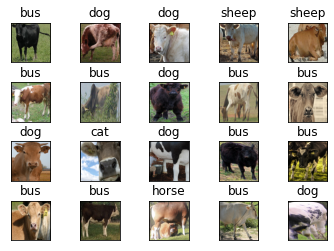

In [ ]:
titles = [classes_classification[i] for i in predIdxs]

n_row = 4
n_col = 5
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks(())
    plt.yticks(())
    plt.subplots_adjust(hspace=0.5)

Model 2 - training on images used to test original classifier

We proceed to train the same model, but this time we are using test images that the model has never seen before

In [ ]:
X_train = test_images_array
Y_train = np_utils.to_categorical(false_test_labels_array, 20)
X_valid = valid_images_array
Y_valid = np_utils.to_categorical(false_valid_labels_array, 20)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Add

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

IMG_SHAPE = train_images_array_cow.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 128)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = Model(inp,reconstruction)


# load the VGG16 network leaving off the FC layers
baseModel = autoencoder
# construct new fully connected layers
headModel = baseModel.output
headModel = Add()([headModel, inp])
headModel = model_ft(headModel)
# place the new fully connected layers on top of the base VGG model
model = Model(inputs=baseModel.input, outputs=headModel)

headModel.trainable = False

# set learning rate and loss function
opt = SGD(lr=2e-4, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt,
	metrics=["accuracy"])

history = model.fit(x=X_train, y=Y_train, epochs=10, validation_data=(X_val, Y_val), batch_size=128)

Train on 782 samples, validate on 1564 samples
Epoch 1/10
782/782 [==============================] - 3s 4ms/step - loss: 2.3113 - accuracy: 0.7020 - val_loss: 1.8543 - val_accuracy: 0.7564
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 1.9173 - accuracy: 0.7020 - val_loss: 1.9973 - val_accuracy: 0.6758
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 1.8255 - accuracy: 0.6419 - val_loss: 1.9138 - val_accuracy: 0.6829
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 1.1371 - accuracy: 0.7353 - val_loss: 1.9442 - val_accuracy: 0.6886
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.8616 - accuracy: 0.7890 - val_loss: 1.9676 - val_accuracy: 0.6957
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.7658 - accuracy: 0.8031 - val_loss: 1.9424 - val_accuracy: 0.6950
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 0.6620 - accuracy: 0.8376 -

Here we visualize results of the perturbation. We can see slight differences between the original image and the perturbed image this time. However the difference is small and the perturbed image still does not look suspicious.

Original Image


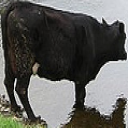

Perturbation


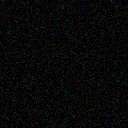

Scaled Perturbation


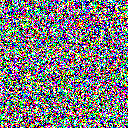

Original Image + Perturbation


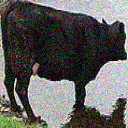

In [ ]:
X_test = train_images_array_cow
Y_test = np_utils.to_categorical(perturbed_cow_labels_test, 20)

layer_outputs = [baseModel.output] 
activation_model = Model(inputs=model.input, outputs=layer_outputs) 
activations = activation_model.predict(X_test)
perturbation_image1 = activations[0]
print("Original Image")
cv2_imshow(X_test[0])
print("Perturbation")
cv2_imshow(perturbation_image1)
print("Scaled Perturbation")
cv2_imshow(perturbation_image1*256)
print("Original Image + Perturbation")
cv2_imshow(X_test[0]+perturbation_image1)

We then test the model of images that the original classifier was trained on. We are more succesful this time, fooling the classifier about 80% of the time.

['aeroplane', 'sofa', 'sheep', 'car', 'cow', 'pottedplant', 'person', 'diningtable', 'tvmonitor', 'chair', 'bottle', 'train', 'bicycle', 'dog', 'boat', 'horse', 'bird', 'motorbike', 'bus', 'cat']


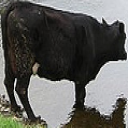

[ 6 18 18 18 18 18  2 18  6 18 18 18 15 11 18 18 18 15 15 18 18  2 18 18
 18 18 18 18 18 15 18 18 19 18 18 18 15  6 18 18 18 15 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 16 18 13 18 18 18  2 18 18 18
 18 18 18 18 18 18 18  6  7 18 18 18 15 18 18  2 18 15 18 15  0 18 18  7
 18 18 15 18 18 18 18 16 18 18 18 18 18 18 15 18 18 18 15 18 18 18 18 18
 18 18 18 18]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00        12
          16       0.00      0.00      0.00         2
          18       0.77      1.00      0.87        96
          19       0.00      0.00      0.00         1

    accuracy             

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
perturbed_cow_labels_train = [classes_classification.index('bus')] * len(train_images_array_cow)

X_test = train_images_array_cow
Y_test = np_utils.to_categorical(perturbed_cow_labels_train, 20)
print(classes_classification)
cv2_imshow(X_test[0])
predIdxs = model.predict(X_test)
predIdxs = np.argmax(predIdxs, axis=1)
print(predIdxs)
ytest_values = np.argmax(Y_test, axis=1)
print(classification_report(predIdxs,ytest_values))

We visualize the first 20 images of the new test set

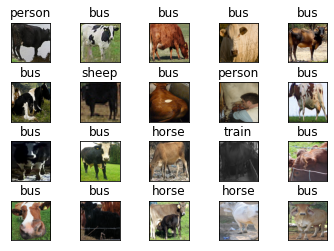

In [ ]:
titles = [classes_classification[i] for i in predIdxs]

n_row = 4
n_col = 5
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks(())
    plt.yticks(())
    plt.subplots_adjust(hspace=0.5)

#### Comparitive Analysis
Both models were successful in fooling the classifier for a large portion of cases. However, Model 2 was more successful in fooling the classifier. Cow images were labeled as “bus” about 80% of the time, compared to 50% for Model 1. This makes sense intuitively, as the classifier in Model 1 had a bias by already learning features on the training images. Model 1, trained on the original classifier’s training images, was able to create almost perfect perturbations. A person would not be able to tell the difference between the original and perturbed images unless they carefully scrutinized them. Model 2 also had good perturbations, however there was a small visual difference when comparing perturbed images to the originals. The perturbations seemed to be of overall greater magnitude when compared with the Model 1. 


####Scenario Analysis

The attack setup is realistic, however the attacker would need full access to the original model’s weights. It would be nearly impossible to train the encoder-decoder to form adversarial perturbations without access to the original classifier. Thus the security of the model is in the hands of protecting the model weights from potential attackers. It would be realistic for an employee to sabotage a model at his place of work. The difference between most of the perturbed images and the originals is imperceptible, making it easy to fool humans. If no steps are taken to protect against adversarial attacks, it would make our original classifier unreliable. However, it would not be difficult to implement defenses against these attacks. The perturbations added to the original images are essentially just noise. Before inputting images into our classifier we could feed them through another encoder-decoder, not connected to the classifier, with the purpose of reconstructing images and reducing overall noise.  


# 4) Discussion

## What we learned

We learned the different components a neural network architecture consists of and what all the different layers do, such as convolutional and max pooling layers. We also learned how a dataset should be split in to a training, validation and test set. In the classification task we learned how we can use a neural network to assign labels to images which are the prediction of our model. For the semantic segmentation we learned how we can label seperate parts of images to the corresponding items in the image, as well as the possibility of augmented our images for the training part when working from scratch. We also learned for both the classification and the semantic segmentation how we can use pretrained models to make the predictions on our dataset. In the adversarial part of the assigment we learned how we could fool a clasiffier by learning a function that generates pertubated images.

## Reflection on the models

The results for the classification task were not that amazing when training from scratch, with an accuracy of around 50%. It is however important to note that we also considered the label of images with multiple objects to be the label of the biggest object present. If we decided to allow a prediction of any label that is present in the images our results would have been slightly better. The usage of data augmentation did allow for slightly better results as well, however as it takes so much longer to train the model with augmented data and only granted a small improvement we do not recommend doing this. However once the model has been trained a first time, updating the model with new images every now and then will not take that long. This could be handy when a company would like to use our system in a live environment. However we do not recommend using our model for classifying images not only due to the quite poor results but also the fact that it is only made to distinguish between 20 classes. This is quite limited for a real world application. If we had more time we could try experimenting with other architectures as well as try to fine tune all the parameters present in the architecture we chose to be optimized for our specific problem.

For classificiation, we did get better results when transferring weights from a pretrained model and finetuning on our images and classes. This method gave us around 75% accuracy compared to 50% on our model trained from scratch. The biggest difference in the fine-tuned model came from its ability to generalize, we saw better accuracy on the test and validation data then on the train data. In contrast to our trained from scratch model which had very high accuracy but performed poorly on unseen data. Another advantage of finetuning is the quick training time, as we are only updating the fully connected layers in the model head, istead of learning new features.

For the segmentation task, the results for the model trained on the unaugmented dataset were very poor. For most images in the test set, the different classes were not segmented accurately, and if they were segmented quite well, the classification (output color) was often wrong. These results were improved slightly by using the augmented dataset, but the overall performance was still not satisfactory. When using the model that was pre-trained on the ImageNet dataset, we were able to improve the results significantly. More test images were segmented and classified more accurately, and the Dice score increased from 0.73-0.74 (training from scratch) to 0.82 (pre-trained model). However, the segmentation results are not perfect, so it would be dangerous to use our segmentation model in a real world setting (e.g. for segmenting objects on the road for autonomous vehicles). If we had more time, we could try to fine-tune the parameters of the model in order to obtain (nearly) perfect segmentation results so that the model could be used in real life. 

Our adversarial attack demonstration highlighted the risks of allowing potential attacks access to your model weights. The method that we utilized is impossible without training on the original classifier, showing the importance of keeping your code private. There are ways to protect against such attacks, but again they rely on the attacker not having access to the original code. Another takeaway from this assignment is the potential instability of deep learning. The perturbed images look identical to the originals and yet, we were succesful in fooling the classifier 50-80% of the time. 


